In [812]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn import metrics, preprocessing
from sklearn.model_selection  import train_test_split 
import statsmodels.formula.api as sm
from operator import itemgetter
import pysal as ps
#import rasterio
import itertools
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
import copy as cp
from sklearn import cluster
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from math import exp

In [813]:
# can use IMD score, as this relates to percentage of people experiencing a certain type of deprivation in a given area

In [1060]:
data_co2 = pd.read_csv('Data/Footprint/bristol_CO2_data', encoding='latin-1').set_index('LSOA')
data_lsoa = gpd.read_file('Data/Spatial/LSOA_EW.shp').set_index('geo_code')
data_cen = pd.read_csv('Data/Census/all_data.csv').set_index('GEO_CODE')
data_imd = pd.read_csv('Data/Census/imd_all_score.csv').set_index('Reference area').join(gpd.read_file('Data/Spatial/LSOA_EW.shp').set_index('geo_label'), how = 'inner').set_index('geo_code').drop('http://opendatacommunities.org/def/ontology/geography/refArea', axis = 1).iloc[:,:9].join(data_co2[['Pastry']], how = 'inner').drop('Pastry', axis=1)

In [1066]:
col_FoodDrink

['Bread_rice_and_cereals',
 'Pasta_products',
 'Buns_cakes_biscuits',
 'Pastry',
 'Beef',
 'Pork',
 'Lamb',
 'Poultry',
 'Bacon_and_ham',
 'Other_meats',
 'Fish_and_fish_products',
 'Milk',
 'Cheese_and_curd',
 'Eggs',
 'Other_milk_products',
 'Butter',
 'Margarine',
 'Cooking_oils_and_fats',
 'Fresh_fruit',
 'Other_fresh_fruits',
 'Dried_fruit_and_nuts',
 'Preserved_fruit',
 'Fresh_vegetables',
 'Dried_vegetables',
 'Other_preserved_vegetables',
 'Potatoes',
 'Other_tubers',
 'Sugar',
 'Jams',
 'Chocolate',
 'Confectionery_products',
 'Edible_ices_and_ice_cream',
 'Other_food_products',
 'Coffee',
 'Tea',
 'Cocoa',
 'Fruit_and_vegetable_juices',
 'Mineral_water',
 'Soft_drinks',
 'Restaurant_and_cafÃ©_meals']

# IMD

In [815]:
data_imd.columns.to_list()

['a. Index of Multiple Deprivation (IMD)',
 'b. Income Deprivation Domain',
 'c. Employment Deprivation Domain',
 'd. Education, Skills and Training Domain',
 'e. Health Deprivation and Disability Domain',
 'f. Crime Domain',
 'g. Barriers to Housing and Services Domain',
 'h. Living Environment Deprivation Domain',
 'i. Income Deprivation Affecting Children Index (IDACI)']

In [816]:
data_imd.columns = data_imd.columns.str[0]
col_list = data_imd.columns.to_list()

In [817]:
ln_col_list = []
z_col_list = []
for item in col_list:
    data_imd[item +'_ln'] = np.log(data_imd[item] + 0.00001)
    ln_col_list.append(item + '_ln')

C:\Users\gylk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A18AA15128>,
      dtype=object)

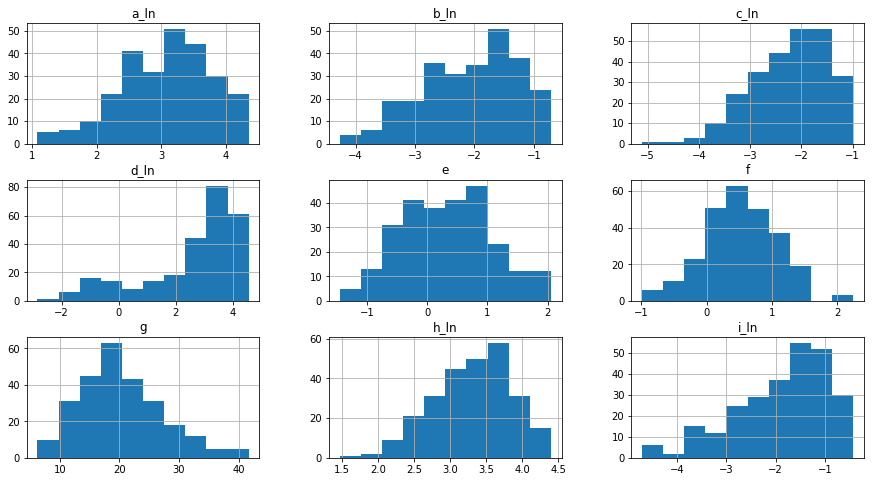

In [818]:
col_list_2 = ['a_ln', 'b_ln', 'c_ln', 'd_ln', 'e', 'f', 'g', 'h_ln', 'i_ln']

#data_imd['a_ln'] = data_imd['a']

data_imd[col_list_2].hist(figsize=(15,8))

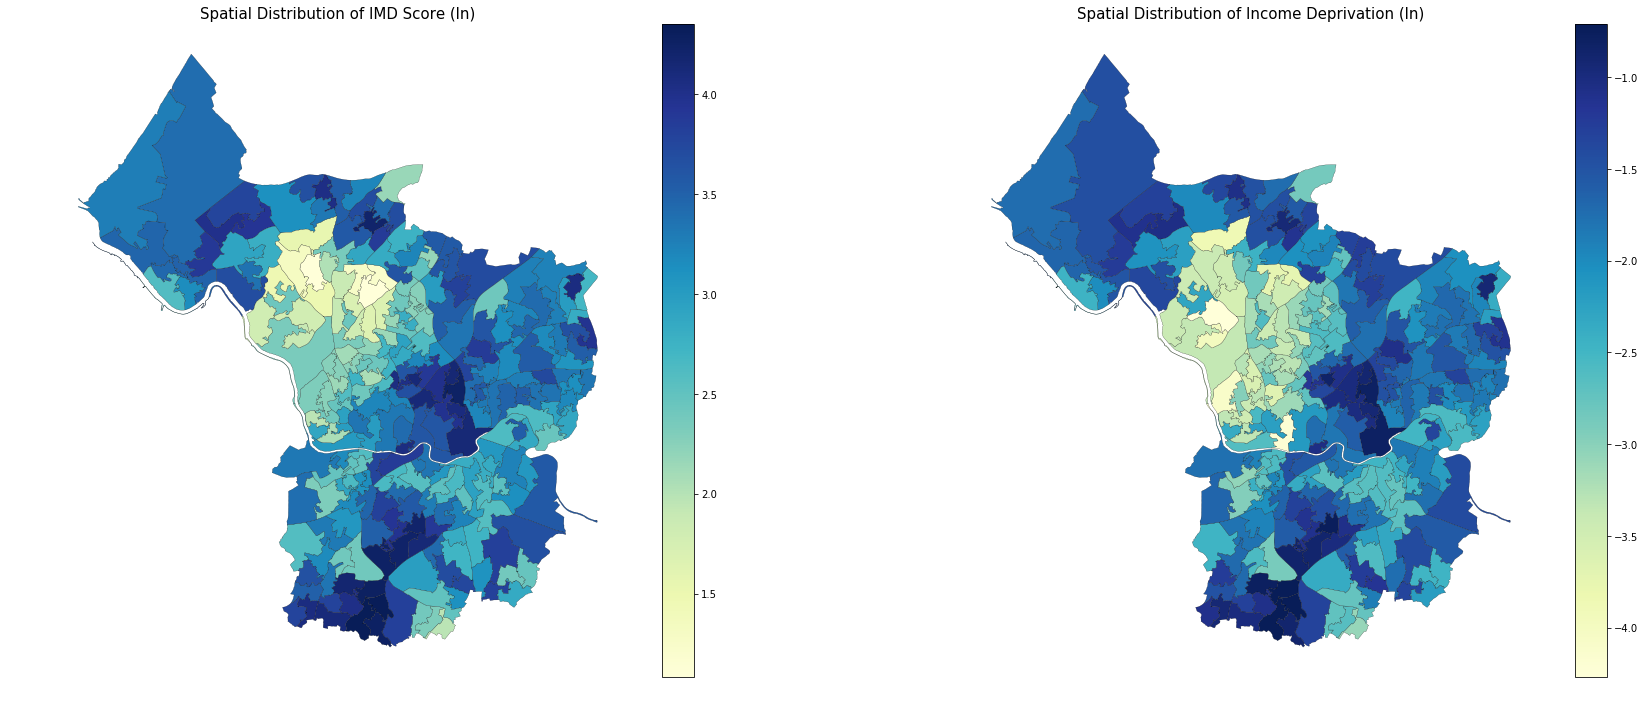

In [819]:
col_list = ['a_ln', 'b_ln']
titles = ['Spatial Distribution of IMD Score (ln)', 'Spatial Distribution of Income Deprivation (ln)']

fig, (axs) = plt.subplots(ncols=len(col_list), nrows=1, figsize=(30, 12))

for i in range(len(col_list)):
    data_lsoa.join(data_imd)\
         .join(data_cen, how = 'inner')\
         .plot(ax=axs[i],
               column=col_list[i], 
               #scheme = 'quantiles',
               cmap='YlGnBu',
               linewidth=0.2, edgecolor='black', 
               legend=True)\
         .set_title(titles[i], size=15)
    axs[i].set_axis_off()
plt.savefig('Outputs/'+col_list[i]+'.png')

In [820]:
data_imd[['a_ln', 'a']].describe()

a_ln           a
count  263.000000  263.000000
mean     3.072119   26.956426
std      0.706326   17.186898
min      1.082825    2.953000
25%      2.536985   12.641500
50%      3.174004   23.903000
75%      3.582379   35.959000
max      4.350562   77.522000

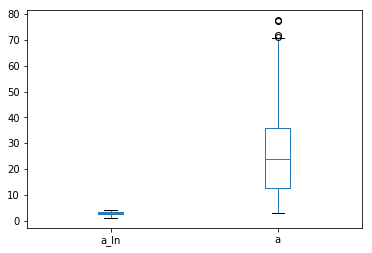

In [821]:
data_imd[['a_ln', 'a']].plot(kind='box')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A19EA72C18>,
      dtype=object)

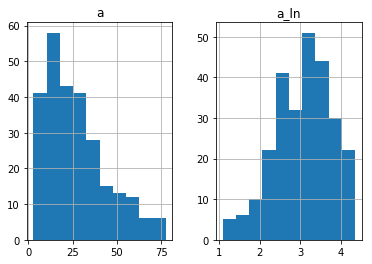

In [822]:
data_imd[['a_ln', 'a']].hist()

# CO2

## by person

In [823]:
data_co2_pop = data_co2.drop(['MSOA', 'LAD', 'LAD_nm', 'REG'], axis=1)

col_co2 = data_co2_pop.columns[:-1].to_list()

data_co2_pop['Pop'] = data_co2_pop['Pop'].str.replace(',', '')
for item in col_co2:
    data_co2_pop[item] = data_co2_pop[item].astype(float) * data_co2_pop['Pop'].astype(float)

In [824]:
pop_sum = 0
for i in range(len(data_co2_pop['Pop'])):
    pop_sum += int(data_co2_pop['Pop'][i])

In [825]:
bristol_sum = data_co2_pop.drop('Pop', axis =1).T

bristol_sum['bristol_tot'] = bristol_sum.sum(axis=1, skipna=True)
bristol_sum = bristol_sum[['bristol_tot']].sort_values('bristol_tot', ascending=False)
bristol_sum['bristol_mean']=bristol_sum['bristol_tot'] / pop_sum

In [826]:
bristol_sum.iloc[0:21, :]#.to_csv('Outputs/CO2_Commodity.csv')

LSOA                                        bristol_tot  bristol_mean
TOTAL                                       3761579.025      8.208180
Gas                                          699090.598      1.525493
Petrol_diesel                                537438.178      1.172749
Electricity                                  520446.500      1.135672
Package_holidays_abroad                      218873.229      0.477606
Other_travel_and_transport                   130953.725      0.285755
Furniture_and_furnishings                     97000.321      0.211665
Water_supply_and_miscellaneous_services       67359.367      0.146986
Purchase_of_second_hand_cars                  66103.337      0.144245
Other_meats                                   60773.252      0.132614
Holiday_in_the_UK                             57600.641      0.125691
Fresh_vegetables                              53010.455      0.115675
Pets_and_pet_food                             51823.337      0.113084
Rail_and_tube_fares                           48360.528      0.105528
Fresh_fruit                                   45780.106      0.099897
Holiday_abroad                                37074.363      0.080900
Vehicle_insurance_including_boat_insurance    33982.407      0.074153
Combined_fares                                31935.306      0.069686
TV_video_and_computers                        30407.959      0.066354
Purchase_of_new_cars                          29497.992      0.064368
Restaurant_and_cafÃ©_meals                    28391.386      0.061953

In [827]:
#bristol_sum[col_FoodDrink].head()#.sum(axis=1)

In [828]:
bristol_sum.describe().T.sort_values('mean', ascending = False).iloc[:, 1:]#.to_csv('Outputs/CO2_Summary.csv')

mean            std  min          25%          50%  \
LSOA                                                                       
bristol_tot   54912.674146  331045.738913  0.0  2789.186000  6813.146000   
bristol_mean      0.119826       0.722378  0.0     0.006086     0.014867   

                       75%           max  
LSOA                                      
bristol_tot   18206.525000  3.761579e+06  
bristol_mean      0.039729  8.208180e+00

In [829]:
col_co2 = data_co2.columns.to_list()

col_FoodDrink = col_co2[:39] + ['Restaurant_and_cafÃ©_meals']
col_AlcTab = col_co2[39:45]
col_clothes = col_co2[45:57]
col_clothes.append(col_co2[127])
col_housing = col_co2[57:60]
col_energy = col_co2[60:64]
col_furniture = col_co2[64:73]
col_health = col_co2[73:76]
col_transport = col_co2[76:87]
col_transport2 = col_transport[5:] # excludes purchases of cars
col_communication = col_co2[87:91]
col_entertainment = col_co2[91:110]
col_travel = col_co2[110:112]
col_travel.append(col_co2[119])
col_travel.append(col_co2[120])
col_travel.append(col_co2[132])
col_education = col_co2[112:114]
col_hospitality = col_co2[114:119]
col_other = col_co2[133:-7]
col_other.append(col_co2[121])
col_toiletries = col_co2[122:127]
col_InsuranceProtection = col_co2[128:132]


cat_list = [col_FoodDrink, col_AlcTab, col_clothes, col_housing, col_energy, col_furniture, col_health, col_transport, col_communication, col_entertainment, col_travel, col_education,\
            col_hospitality, col_other, col_toiletries, col_InsuranceProtection, col_transport2]

cat_str = ['col_FoodDrink', 'col_AlcTab', 'col_clothes', 'col_housing', 'col_energy', 'col_furniture', 'col_health', 'col_transport', 'col_communication', 'col_entertainment', 'col_travel', 'col_education',\
           'col_hospitality', 'col_other', 'col_toiletries', 'col_InsuranceProtection', 'col_transport2']

In [830]:
bristol_sum = bristol_sum.T
for i in range(len(cat_list)):
    bristol_sum[cat_str[i]] = bristol_sum[cat_list[i]].sum(axis=1)
    
bristol_sum[cat_str].T.sort_values('bristol_tot', ascending = False)#.to_csv('Outputs/CO2_Sectors.csv')

LSOA                     bristol_tot  bristol_mean
col_energy               1315125.288      2.869748
col_transport             906737.314      1.978601
col_FoodDrink             452099.058      0.986530
col_travel                328029.261      0.715796
col_transport2            254791.748      0.555984
col_entertainment         205252.426      0.447883
col_furniture             169780.487      0.370480
col_clothes                89477.058      0.195249
col_InsuranceProtection    64115.224      0.139906
col_hospitality            59335.349      0.129476
col_health                 45682.510      0.099684
col_toiletries             40525.377      0.088431
col_communication          38549.628      0.084120
col_housing                19770.606      0.043142
col_other                  18064.086      0.039418
col_AlcTab                 14663.781      0.031998
col_education              14482.841      0.031603

## by LSOA

In [831]:
summary_co2 = data_co2.drop('TOTAL', axis = 1).describe().loc[['mean', 'std', 'min', 'max']].T
summary_co2['range'] = summary_co2['max'] - summary_co2['min']
#summary_co2.sort_values('range', ascending=False).iloc[:20,:]

In [832]:
#summary_co2.sort_values('mean', ascending=False).iloc[:20,:]

In [833]:
for i in range(len(cat_list)):
    data_co2[cat_str[i]] = data_co2[cat_list[i]].sum(axis=1)

In [834]:
summary_co2 = data_co2.drop('TOTAL', axis = 1).describe().loc[['mean', 'std', 'min', 'max']].T
summary_co2['range'] = summary_co2['max'] - summary_co2['min']
summary_co2.T[cat_str].T.sort_values('range', ascending=False)#.to_csv('Outputs/CO2_SecSum.csv')

#summary_co2.drop(cat_str)['range'].sort_values().plot(kind='barh', figsize=(20, 20))
#summary_co2.T[cat_str].T.sort_values('mean', ascending=False)

mean       std    min    max  range
col_transport            1.974624  0.221818  1.528  2.425  0.897
col_travel               0.713544  0.102598  0.538  0.959  0.421
col_energy               2.868977  0.083785  2.711  3.113  0.402
col_transport2           0.554867  0.078682  0.425  0.770  0.345
col_FoodDrink            0.985411  0.051702  0.883  1.105  0.222
col_entertainment        0.447000  0.039360  0.361  0.530  0.169
col_furniture            0.369681  0.035177  0.300  0.442  0.142
col_clothes              0.194989  0.017335  0.162  0.232  0.070
col_InsuranceProtection  0.139646  0.012717  0.113  0.167  0.054
col_hospitality          0.129247  0.013653  0.103  0.157  0.054
col_health               0.099392  0.010791  0.075  0.124  0.049
col_toiletries           0.088300  0.007349  0.073  0.105  0.032
col_housing              0.043053  0.004882  0.037  0.061  0.024
col_communication        0.084042  0.004976  0.073  0.096  0.023
col_education            0.031620  0.003536  0.025  0.043  0.018
col_other                0.039376  0.003155  0.032  0.048  0.016
col_AlcTab               0.031947  0.002061  0.028  0.036  0.008

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A157144908>]],
      dtype=object)

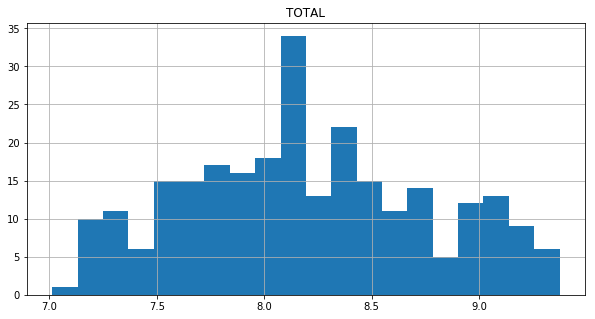

In [835]:
#data_co2[cat_str].hist(figsize=(30,20))
data_co2[['TOTAL']].hist(figsize=(10,5), bins=20)

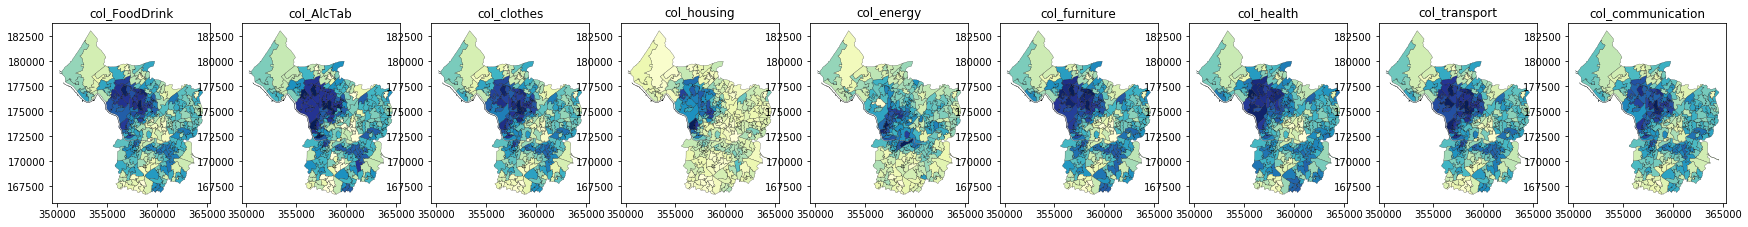

In [836]:
fig, (axs) = plt.subplots(ncols=int((len(cat_str)+1)/2), nrows=1, figsize=(30, 8))

for i in range(0, int((len(cat_str)+1)/2)):
    data_lsoa.join(data_co2[cat_str], how = 'inner')\
             .plot(ax=axs[i],
                   column=cat_str[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(cat_str[i])

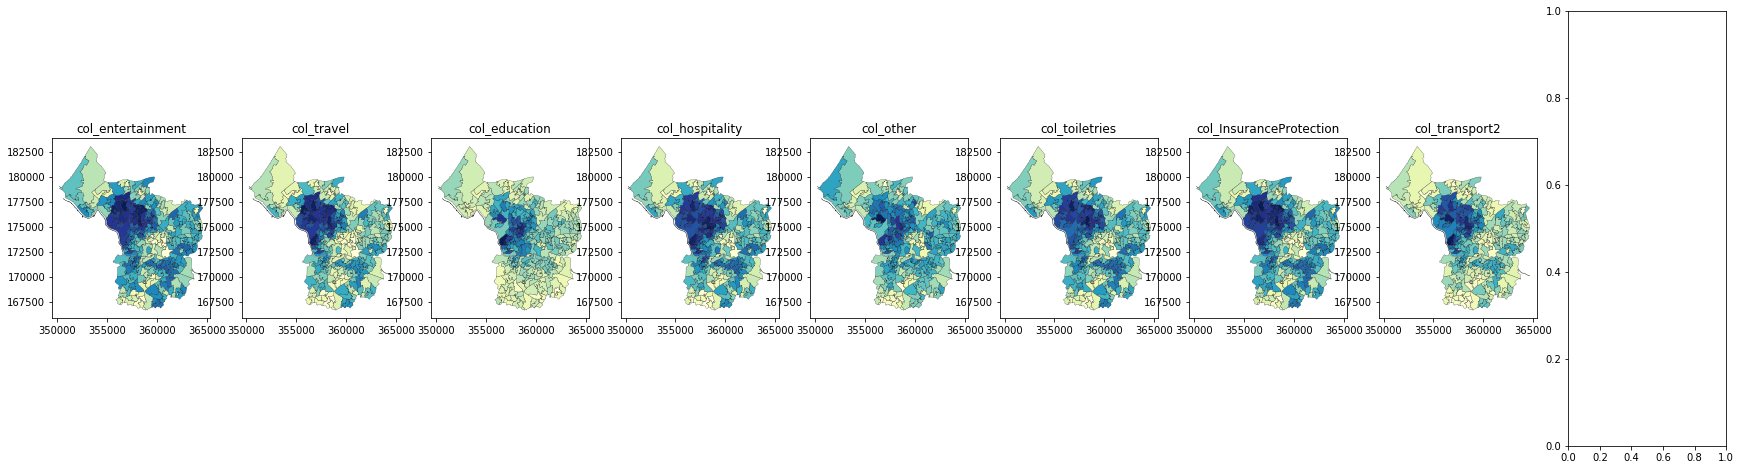

In [837]:
a = (len(cat_str) - int(len(cat_str)/2))

fig, (axs) = plt.subplots(ncols=a, nrows=1, figsize=(30, 8))

for i in range(a, len(cat_str)):
    data_lsoa.join(data_co2[cat_str], how = 'inner')\
             .plot(ax=axs[i-a],
                   column=cat_str[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(cat_str[i])

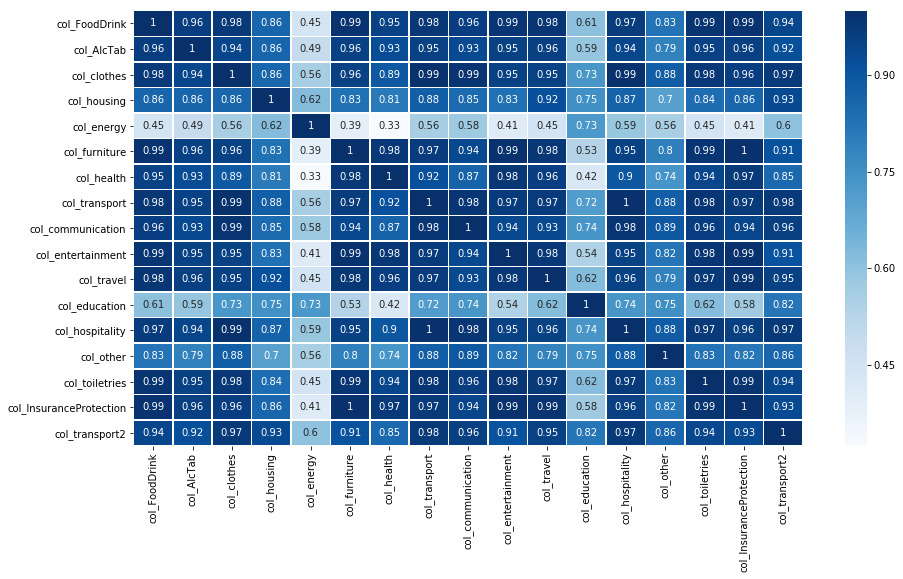

In [838]:
plt.subplots(figsize=(15,8))
sns.heatmap(data_co2[cat_str].corr(), annot=True, cmap='Blues', linewidths=.5)
plt.show()

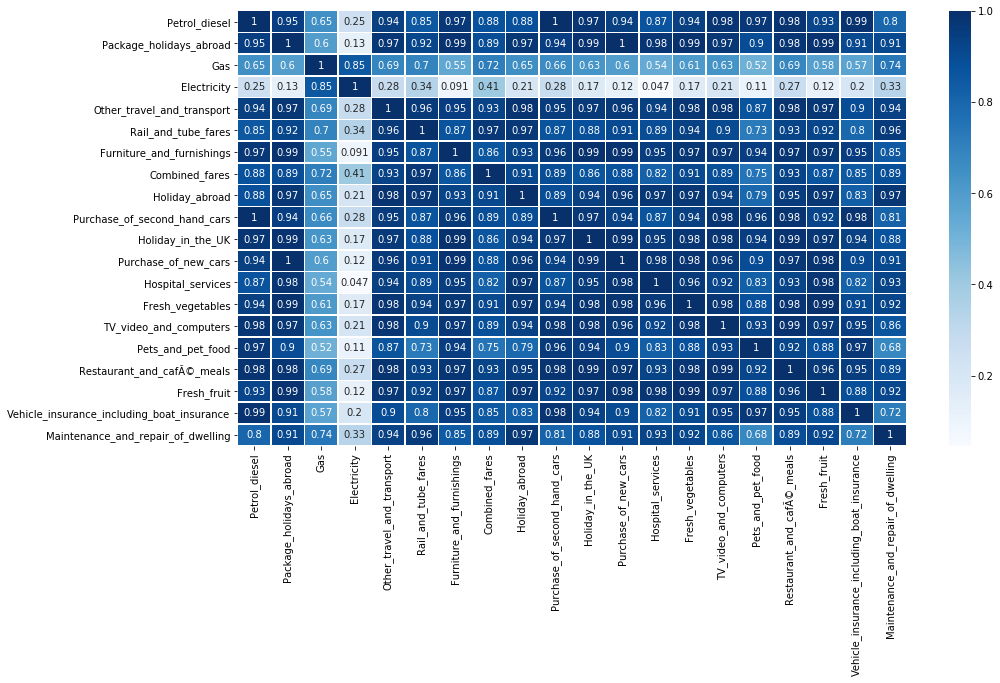

In [839]:
range_sorted = summary_co2.sort_values('range', ascending=False).T.drop(cat_str, axis=1).columns.to_list()

plt.subplots(figsize=(15,8))
sns.heatmap(data_co2[range_sorted[:20]].corr(), annot=True, cmap='Blues', linewidths=.5)
plt.show()

In [840]:
'''
a = range_sorted[:7]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''
# looks like Gas and Electricity may be more linked to housing types / efficiency than to deprivation?

"\na = range_sorted[:7]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

In [841]:
'''
a = range_sorted[7:14]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''

"\na = range_sorted[7:14]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

In [842]:
'''
a = range_sorted[14:21]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''

"\na = range_sorted[14:21]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

Text(1182.83,0.5,'Total CO2 emissions per capita')

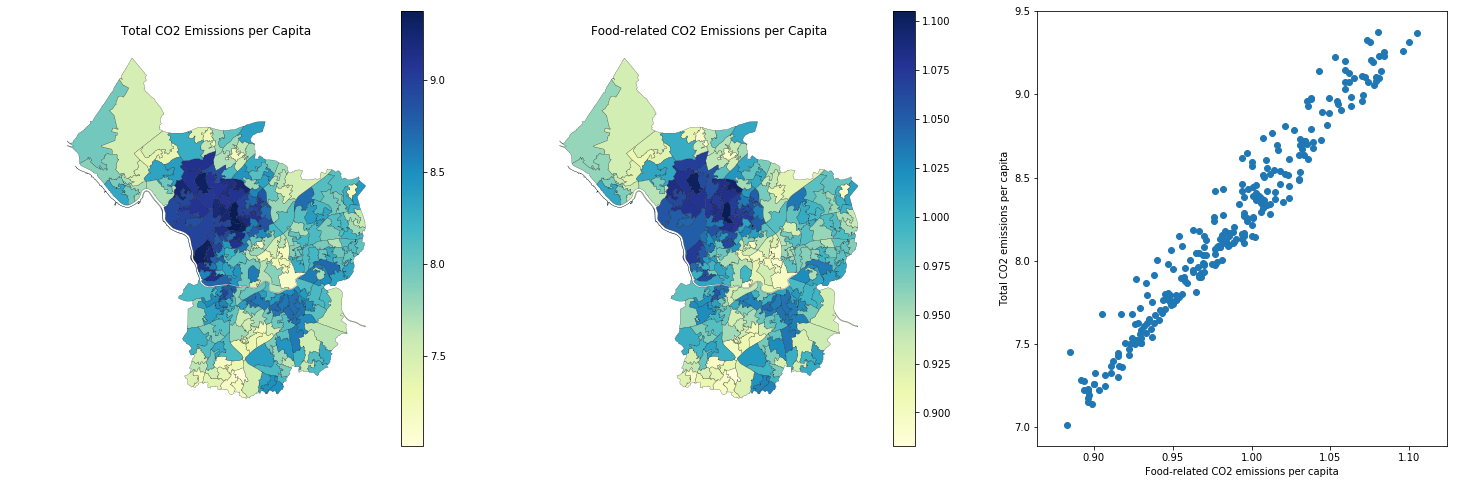

In [843]:
data_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 8))

data_lsoa.join(data_co2, how='right')\
         .plot(ax=axs[0],
               column='TOTAL', 
               cmap='YlGnBu',
               linewidth=0.2, edgecolor='black', 
               legend=True)\
         .set_title("Total CO2 Emissions per Capita")
axs[0].set_axis_off()

data_lsoa.join(data_co2, how='right')\
         .plot(ax=axs[1],
               column='food_total', 
               cmap='YlGnBu',
               linewidth=0.2, edgecolor='black', 
               legend=True)\
         .set_title("Food-related CO2 Emissions per Capita")
axs[1].set_axis_off()

axs[2] = plt.scatter(data_co2['food_total'], data_co2['TOTAL'])
plt.xlabel('Food-related CO2 emissions per capita')
plt.ylabel('Total CO2 emissions per capita')

# plt.savefig('Outputs/total_co2.png')

In [844]:
'''
a = summary_co2.T[col_FoodDrink].T.sort_values('mean', # use 'range', 'mean' or 'max'
                                               ascending=False).index.to_list()[:10] # use [:10], [10:20] or [20]

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''

"\na = summary_co2.T[col_FoodDrink].T.sort_values('mean', # use 'range', 'mean' or 'max'\n                                               ascending=False).index.to_list()[:10] # use [:10], [10:20] or [20]\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

In [845]:
top_list = summary_co2.T[col_FoodDrink].T.sort_values('mean', ascending=False).index.to_list()[:10]

for item in summary_co2.T[col_FoodDrink].T.sort_values('range', ascending=False).index.to_list()[:10]:
    if item not in top_list:
        top_list.append(item)
        
for item in summary_co2.T[col_FoodDrink].T.sort_values('max', ascending=False).index.to_list()[:10]:
    if item not in top_list:
        top_list.append(item)
        
print(top_list)

# could also look at lowest ranges (staples?)

['Other_meats', 'Fresh_vegetables', 'Fresh_fruit', 'Restaurant_and_cafÃ©_meals', 'Bread_rice_and_cereals', 'Poultry', 'Other_food_products', 'Buns_cakes_biscuits', 'Beef', 'Other_tubers']


In [846]:
'''
a = top_list

fig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))

for i in range(len(a)):
    data_lsoa.join(data_co2[a], how = 'inner')\
             .plot(ax=axs[i],
                   column=a[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(a[i])
'''  
# maybe lack of milk in affluent area becasue people buy more plant milks? --> or could be just relatively less to other areas
# this would explain why other dairy products are still high --> not as 'trendy' and accessible as plant based milks

"\na = top_list\n\nfig, (axs) = plt.subplots(ncols=len(a), nrows=1, figsize=(30, 8))\n\nfor i in range(len(a)):\n    data_lsoa.join(data_co2[a], how = 'inner')             .plot(ax=axs[i],\n                   column=a[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(a[i])\n"

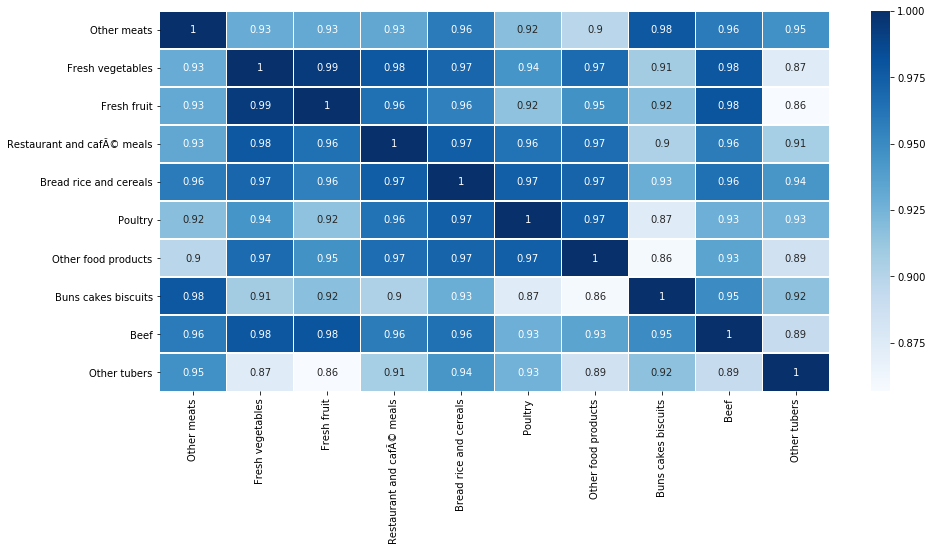

In [847]:
col_names_tl = []
for item in top_list:
    item2 = item.replace('_', ' ')
    col_names_tl.append(item2)

data_tl = data_co2[top_list]
data_tl.columns = col_names_tl

plt.subplots(figsize=(15, 7))
sns.heatmap(data_tl.corr(), annot=True, 
            cmap='Blues', linewidths=.5)
plt.savefig('Outputs/top_cor_an.png')
plt.show()

In [848]:
#data_co2[top_list].plot(kind='box', figsize=(20,8))

In [849]:
#data_co2[top_list].hist(figsize=(10,10), bins=5)

In [934]:
grains = summary_co2.T[col_FoodDrink].columns.to_list()[:2]
baked = summary_co2.T[col_FoodDrink].columns.to_list()[2:4]
meat = summary_co2.T[col_FoodDrink].columns.to_list()[4:11]
dairy_eggs = summary_co2.T[col_FoodDrink].columns.to_list()[11:16] + ['Edible_ices_and_ice_cream']
fats = summary_co2.T[col_FoodDrink].columns.to_list()[16:18]
fruit_veg = summary_co2.T[col_FoodDrink].columns.to_list()[18:27]
sweets_other = summary_co2.T[col_FoodDrink].columns.to_list()[27:31]
drinks_nonalc = summary_co2.T[col_FoodDrink].columns.to_list()[33:-1]
other = ['Other_food_products']

In [935]:
data_co2_totalsum = data_co2[col_FoodDrink + ['Pop']]

data_co2_totalsum['Pop'] = data_co2_totalsum['Pop'].str.replace(',', '').astype(float)

for col in data_co2_totalsum.columns.tolist()[:-1]:
    data_co2_totalsum[col] = data_co2_totalsum[col] * data_co2_totalsum['Pop']
    
data_co2_totalsum = data_co2_totalsum.drop('Pop', axis=1)

col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats, other]
str_list = ['Fruit and Veg', 'Meat', 'Grains', 'Dairy and Eggs', 'Sweets', 'Baked Goods', 'Drinks (non-alc.)', 'Cooking Oils and Fats', 'Other']
tot_list = []

for i in range(len(col_list)):
    data_co2_totalsum[str_list[i]] = data_co2_totalsum[col_list[i]].sum(axis=1)
    tot_list.append(str(str_list[i]))
    
data_co2_totalsum[str_list + ['Restaurant_and_cafÃ©_meals']].sum().sort_values(ascending=False)

C:\Users\gylk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\gylk\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Fruit and Veg                 138813.376
Meat                          133284.196
Dairy and Eggs                 43940.241
Grains                         30618.291
Restaurant_and_cafÃ©_meals     28391.386
Baked Goods                    24688.721
Other                          22141.964
Drinks (non-alc.)              14195.340
Sweets                         11585.119
Cooking Oils and Fats           4440.424
dtype: float64

In [852]:
col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]
str_list = ['Fruit and Veg', 'Meat', 'Grains', 'Dairy and Eggs', 'Other', 'Baked Goods', 'Drinks (non-alc.)', 'Cooking Oils and Fats']
tot_list = []

for i in range(len(col_list)):
    data_co2[str(str_list[i])] = data_co2[col_list[i]].sum(axis=1)
    tot_list.append(str(str_list[i]))

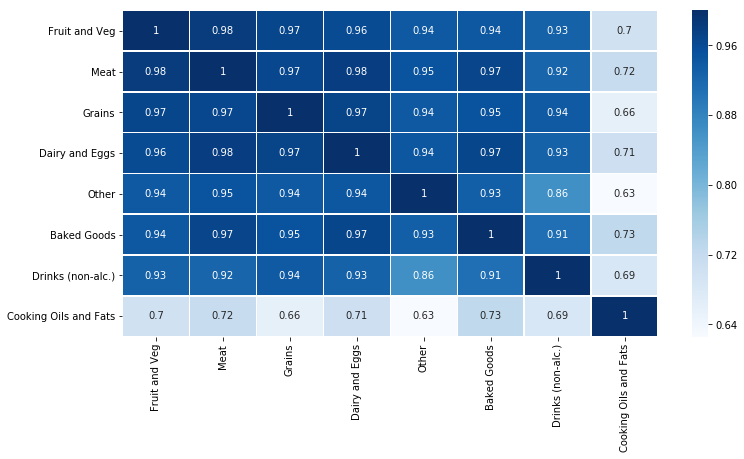

In [853]:
plt.subplots(figsize=(12,6))
sns.heatmap(data_co2[tot_list].corr(), annot=True, 
            cmap='Blues', linewidths=.5)
#plt.savefig('Outputs/cat_cor.png')
plt.show()
# really high co-variance --> likely because does not control for AMOUNT actually consumed, only spending data

# look at total food and/or top_list, becasue covariance so high that there is no need for looking at these separately 

In [854]:
data_co2[tot_list].describe().T.iloc[:,1:].sort_values('mean', ascending=False)#.to_csv('Outputs/cat_means.csv')

mean       std    min    25%    50%    75%    max
Fruit and Veg          0.302555  0.016896  0.271  0.290  0.301  0.313  0.345
Meat                   0.298639  0.013532  0.271  0.288  0.299  0.309  0.329
Dairy and Eggs         0.087673  0.003726  0.080  0.085  0.088  0.090  0.095
Grains                 0.066757  0.003148  0.060  0.065  0.067  0.069  0.075
Baked Goods            0.053825  0.002321  0.048  0.052  0.054  0.056  0.059
Drinks (non-alc.)      0.030935  0.002041  0.027  0.030  0.031  0.032  0.035
Other                  0.025247  0.001297  0.023  0.024  0.025  0.026  0.028
Cooking Oils and Fats  0.009673  0.000579  0.009  0.009  0.010  0.010  0.011

In [855]:
'''
# Scale the data to fit between 0 and 1. This will be useful for the K-Means analysis, as euclidian distance is used. 

min_max_scaler = preprocessing.MinMaxScaler()
data_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[tot_list]))
data_mm.index = data_co2[tot_list].index

to_keep = data_co2[tot_list].columns.to_list()
to_keep_mm = []
for var in to_keep:
    to_keep_mm.append(var + '_mm')
data_mm.columns = to_keep_mm


data_food_tot = data_co2[tot_list].join(data_mm)[to_keep_mm]

data_food_tot.head()
'''

"\n# Scale the data to fit between 0 and 1. This will be useful for the K-Means analysis, as euclidian distance is used. \n\nmin_max_scaler = preprocessing.MinMaxScaler()\ndata_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[tot_list]))\ndata_mm.index = data_co2[tot_list].index\n\nto_keep = data_co2[tot_list].columns.to_list()\nto_keep_mm = []\nfor var in to_keep:\n    to_keep_mm.append(var + '_mm')\ndata_mm.columns = to_keep_mm\n\n\ndata_food_tot = data_co2[tot_list].join(data_mm)[to_keep_mm]\n\ndata_food_tot.head()\n"

# CENSUS

In [856]:
# see Data/Census/meta_dict.json for descirptions

# tranfrom ns-sec variable
nssec = ['F359631', 'F359633', 'F359635', 'F359637', 'F359639', 'F359641', 'F359643', 'F359645']
data_ns = data_cen[nssec]

data_cen['max'] = 'empty'
data_cen.loc[data_ns.F359631 == data_ns.max(axis=1), 'max'] = 'S1'
data_cen.loc[data_ns.F359633 == data_ns.max(axis=1), 'max'] = 'S2'
data_cen.loc[data_ns.F359635 == data_ns.max(axis=1), 'max'] = 'S3'
data_cen.loc[data_ns.F359637 == data_ns.max(axis=1), 'max'] = 'S4'
data_cen.loc[data_ns.F359639 == data_ns.max(axis=1), 'max'] = 'S5'
data_cen.loc[data_ns.F359641 == data_ns.max(axis=1), 'max'] = 'S6'
data_cen.loc[data_ns.F359643 == data_ns.max(axis=1), 'max'] = 'S7'
data_cen.loc[data_ns.F359645 == data_ns.max(axis=1), 'max'] = 'S8'

# Create Dummy Variables
nssec_dm = pd.get_dummies(data_cen['max'], prefix='nssec')
data_cen = data_cen.join(nssec_dm)
#data_cen = data_cen.drop(['nssec_S8'], axis=1)

#transform other variables
data_cen['emp_ft'] = data_cen['F1393'] + data_cen['F1395'] + data_cen['F1397']
data_cen['bdr_1p'] = data_cen['F2071'] + data_cen['F2073']
data_cen['eth_w'] = data_cen['F1664'] + data_cen['F1665'] + data_cen['F1666'] + data_cen['F1667']
data_cen['eth_w_ln'] = 1/(data_cen['eth_w'])
data_cen['sec8_ln'] = np.log(data_cen['F359645'])
data_cen['buk_ln'] = np.log(data_cen['F884'])
data_cen['eur'] = data_cen['F1221'] + data_cen['F1233']
data_cen['noneur'] = 1-data_cen['eur']
data_cen['ptrs'] = data_cen['F209'] + data_cen['F210']

# All

In [857]:
'''
col_list = data.columns.to_list()

fig, (axs) = plt.subplots(ncols=len(col_list), nrows=1, figsize=(30, 8))

for i in range(len(col_list)):
    data_lsoa.join(data, how = 'inner').dropna(axis=1)\
             .plot(ax=axs[i],
                   column=col_list[i], 
                   cmap='YlGnBu',
                   linewidth=0.2, edgecolor='black',
                   #legend=True
                  )\
             .set_title(col_list[i])
'''

"\ncol_list = data.columns.to_list()\n\nfig, (axs) = plt.subplots(ncols=len(col_list), nrows=1, figsize=(30, 8))\n\nfor i in range(len(col_list)):\n    data_lsoa.join(data, how = 'inner').dropna(axis=1)             .plot(ax=axs[i],\n                   column=col_list[i], \n                   cmap='YlGnBu',\n                   linewidth=0.2, edgecolor='black',\n                   #legend=True\n                  )             .set_title(col_list[i])\n"

In [858]:
data_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)

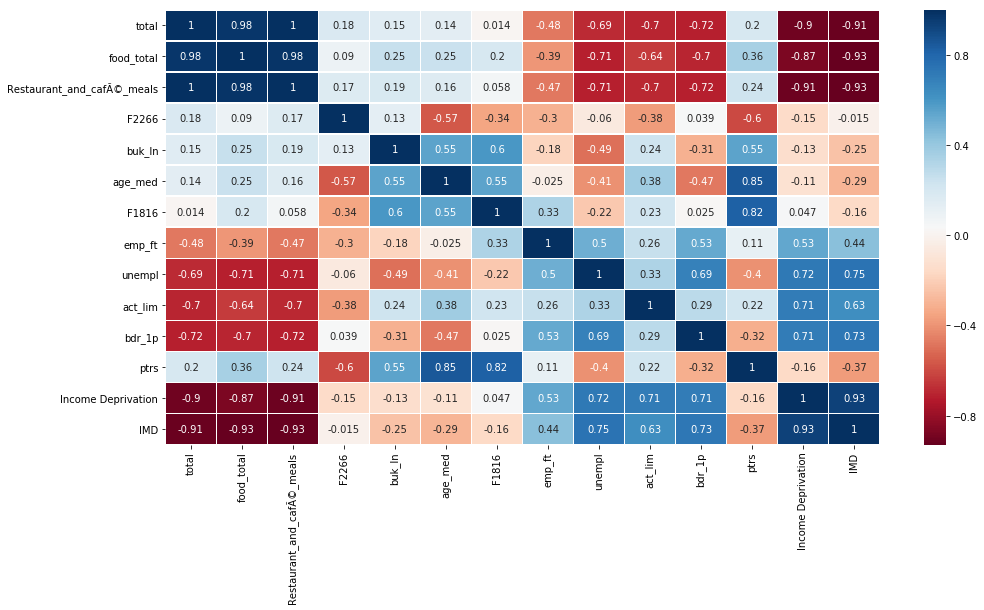

In [859]:

col_names={'F185':'age_med', 'F184':'age_mean', 'F1916':'act_lim', 'F1399':'unempl', 'TOTAL':'total', 'a_ln':'IMD', 'b_ln':'Income Deprivation'}

cen_keep = ['F2266', 'buk_ln', 'F185', 'F1816', 'emp_ft', 'F1399', 'F1916', 'bdr_1p', 'ptrs']
data_co2['food_total'] = data_co2[col_FoodDrink].sum(axis=1)
data = data_co2[['TOTAL', 'food_total', 'Restaurant_and_cafÃ©_meals']].join(data_cen[cen_keep], how='inner').join(data_imd[['b_ln', 'a_ln']]).rename(columns=col_names)


plt.subplots(figsize=(16,8))
sns.heatmap(data.corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()


In [860]:
'''
sns.set(style="ticks")
sns.pairplot(data)
'''

'\nsns.set(style="ticks")\nsns.pairplot(data)\n'

In [861]:
"""
['a. Index of Multiple Deprivation (IMD)',
 'b. Income Deprivation Domain',
 'c. Employment Deprivation Domain',
 'd. Education, Skills and Training Domain',
 'e. Health Deprivation and Disability Domain',
 'f. Crime Domain',
 'g. Barriers to Housing and Services Domain',
 'h. Living Environment Deprivation Domain',
 'i. Income Deprivation Affecting Children Index (IDACI)']
 """

'''
col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]

check_var = col_list[7]

plt.subplots(figsize=(30, 15))
sns.heatmap(data_co2[check_var].join(data_imd[col_list_2]).corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()

# h most different for all foods, also check f and g
# maybe milk is weird because people buy plant milks more? 
'''

"\ncol_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]\n\ncheck_var = col_list[7]\n\nplt.subplots(figsize=(30, 15))\nsns.heatmap(data_co2[check_var].join(data_imd[col_list_2]).corr(), annot=True, cmap='RdBu', linewidths=.5)\nplt.show()\n\n# h most different for all foods, also check f and g\n# maybe milk is weird because people buy plant milks more? \n"

In [862]:
'''
sns.set(style="ticks")
sns.pairplot(data_imd[col_list_2], kind = 'reg', plot_kws={'line_kws':{'color':'red'}})
'''

'\nsns.set(style="ticks")\nsns.pairplot(data_imd[col_list_2], kind = \'reg\', plot_kws={\'line_kws\':{\'color\':\'red\'}})\n'

In [863]:
'''
col_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]

check_var = col_list[0]

sns.set(style="ticks")
sns.pairplot(data_co2[check_var].join(data_imd[['a_ln', 'f', 'g', 'h_ln']]), kind = 'reg', plot_kws={'line_kws':{'color':'red'}})
'''

# h maybe correlates with: Potatoes, Other-tubers, Lamb, Bacon_and_ham, Pasta_products, Milk, Butter, Other_food_products, Pastry, Tea, Mineral_water, Soft_drinks, Margarine

'\ncol_list = [fruit_veg, meat, grains, dairy_eggs, sweets_other, baked, drinks_nonalc, fats]\n\ncheck_var = col_list[0]\n\nsns.set(style="ticks")\nsns.pairplot(data_co2[check_var].join(data_imd[[\'a_ln\', \'f\', \'g\', \'h_ln\']]), kind = \'reg\', plot_kws={\'line_kws\':{\'color\':\'red\'}})\n'

In [864]:
# col_list_3 = ['Potatoes', 'Other_tubers', 'Lamb', 'Bacon_and_ham', 'Pasta_products', 'Milk', 'Butter', 'Other_food_products', 'Pastry', 'Tea', 'Mineral_water', 'Soft_drinks', 'Margarine']

'''
col_list_3 = ['Potatoes', 'Lamb', 'Bacon_and_ham', 'Butter', 'Pastry', 'Tea', 'Mineral_water', 'Soft_drinks', 'Margarine']

plt.subplots(figsize=(16, 8))
sns.heatmap(data_co2[col_list_3].join(data_imd[['a_ln']]).corr(), annot=True, cmap='RdBu', linewidths=.5)
plt.show()
'''

"\ncol_list_3 = ['Potatoes', 'Lamb', 'Bacon_and_ham', 'Butter', 'Pastry', 'Tea', 'Mineral_water', 'Soft_drinks', 'Margarine']\n\nplt.subplots(figsize=(16, 8))\nsns.heatmap(data_co2[col_list_3].join(data_imd[['a_ln']]).corr(), annot=True, cmap='RdBu', linewidths=.5)\nplt.show()\n"

In [865]:
'''
a = ['Restaurant_and_cafÃ©_meals', 'a_ln']

fig, (axs) = plt.subplots(ncols=int(len(a)), nrows=1, figsize=(30, 8))

data_a = data_lsoa.join(data_imd, how = 'inner').join(data_co2, how = 'inner')

for i in range(len(a)):
    data_a.plot(ax=axs[i],
                column=a[i], 
                cmap='YlGnBu',
                scheme = 'quantiles',
                linewidth=0.2, edgecolor='black',
                legend=True
                )\
           .set_title(a[i], size=13)
    axs[i].set_axis_off()
'''

"\na = ['Restaurant_and_cafÃ©_meals', 'a_ln']\n\nfig, (axs) = plt.subplots(ncols=int(len(a)), nrows=1, figsize=(30, 8))\n\ndata_a = data_lsoa.join(data_imd, how = 'inner').join(data_co2, how = 'inner')\n\nfor i in range(len(a)):\n    data_a.plot(ax=axs[i],\n                column=a[i], \n                cmap='YlGnBu',\n                scheme = 'quantiles',\n                linewidth=0.2, edgecolor='black',\n                legend=True\n                )           .set_title(a[i], size=13)\n    axs[i].set_axis_off()\n"

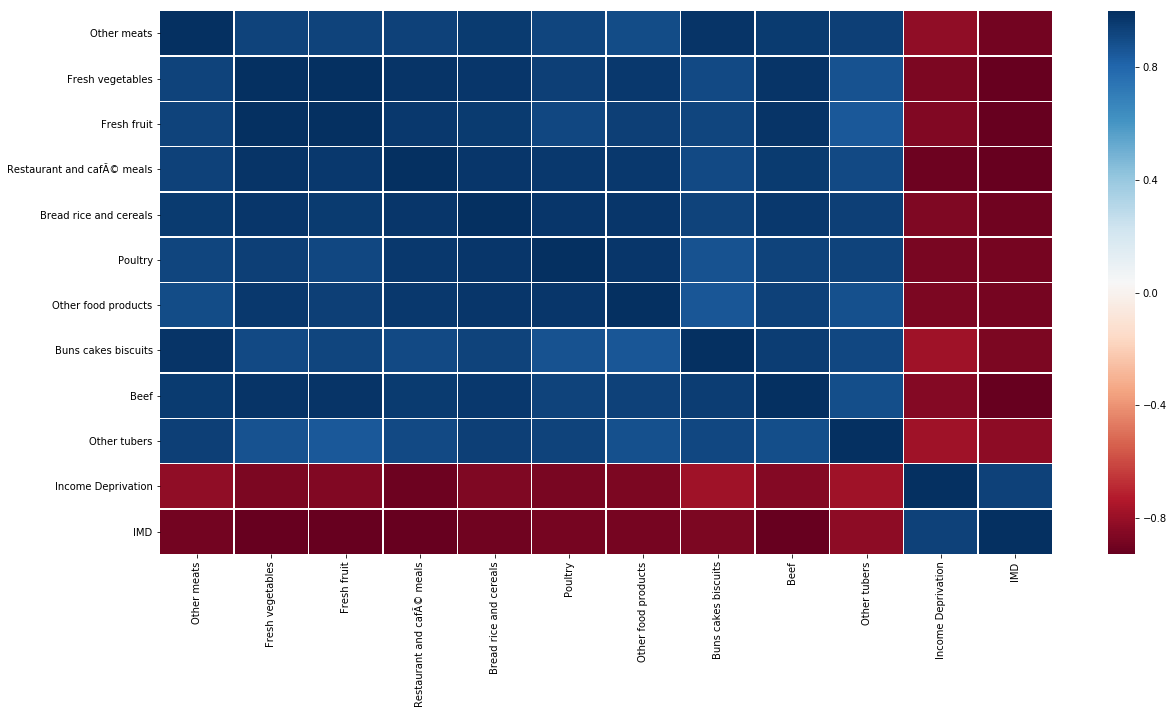

In [866]:
plt.subplots(figsize=(20,10))
sns.heatmap(data_tl.join(data_imd[['b_ln', 'a_ln']]).rename(columns=col_names).corr(),# annot=True, 
            cmap='RdBu', linewidths=.5)
plt.savefig('Outputs/tl_imd.png')
plt.show()

In [867]:
'''
sns.set(style="ticks")
sns.pairplot(data_co2[top_list].join(data_imd[['b_ln', 'a_ln']]))
'''

'\nsns.set(style="ticks")\nsns.pairplot(data_co2[top_list].join(data_imd[[\'b_ln\', \'a_ln\']]))\n'

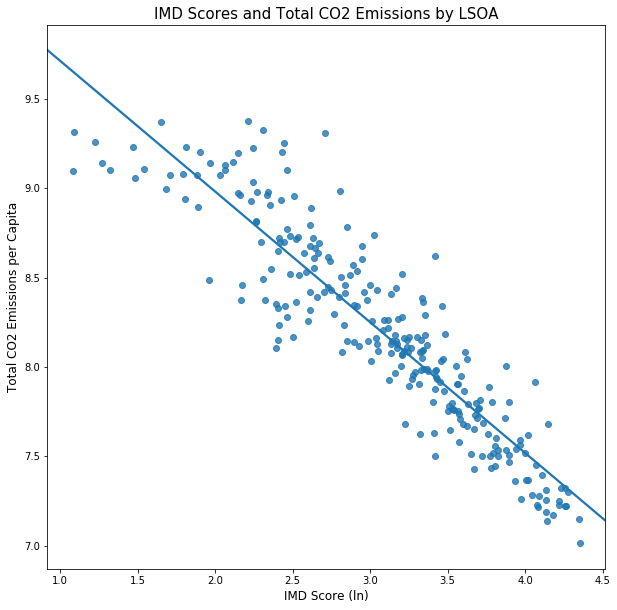

In [868]:
f, (ax) = plt.subplots(nrows =1, ncols=1, figsize=(10,10))

sns.regplot(ax=ax, x="IMD", y="total", data=data, ci=None)
ax.set_title("IMD Scores and Total CO2 Emissions by LSOA", size=15)
plt.xlabel('IMD Score (ln)', size=12)
plt.ylabel('Total CO2 Emissions per Capita', size=12)

plt.savefig('Outputs/imd_total_plot.png')

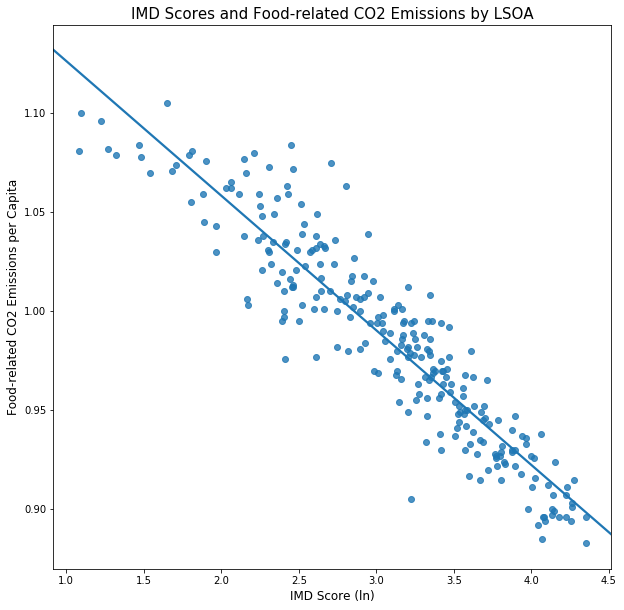

In [869]:
f, (ax1) = plt.subplots(nrows =1, ncols=1, figsize=(10,10))

sns.regplot(ax=ax1, x="IMD", y="food_total", data=data, ci=None)
#ax1.set_ylim(0.8, 1.07)
plt.xlabel('IMD Score (ln)', size=12)
plt.ylabel('Food-related CO2 Emissions per Capita', size=12)

ax1.set_title("IMD Scores and Food-related CO2 Emissions by LSOA", size=15)
plt.savefig('Outputs/imd_food_plot.png')

# Regression

In [870]:
data.head()

total  food_total  Restaurant_and_cafÃ©_meals     F2266    buk_ln  \
LSOA                                                                           
E01014485  8.178       0.983                       0.061  0.492570 -0.924997   
E01014486  7.806       0.947                       0.056  0.381096 -1.052848   
E01014487  8.783       1.027                       0.068  0.534500 -0.857432   
E01014488  8.519       1.012                       0.065  0.523833 -0.896050   
E01014489  8.044       0.967                       0.059  0.496879 -0.939125   

           age_med     F1816    emp_ft    unempl   act_lim    bdr_1p  \
LSOA                                                                   
E01014485     33.0  0.568571  0.156212  0.034440  0.068244  0.211353   
E01014486     30.0  0.482446  0.165730  0.100187  0.079845  0.226015   
E01014487     28.0  0.523169  0.110512  0.020216  0.039000  0.177045   
E01014488     31.0  0.581699  0.148148  0.035760  0.051179  0.225847   
E01014489     29.0  0.431567  0.150772  0.076294  0.065751  0.201754   

               ptrs  Income Deprivation       IMD  
LSOA                                               
E01014485  0.236253           -1.720314  3.158362  
E01014486  0.219672           -1.087643  3.892677  
E01014487  0.261837           -2.717949  2.853939  
E01014488  0.242259           -1.660679  3.204331  
E01014489  0.144775           -1.514082  3.622125

In [871]:
def calculate_model(out, pred):
    m_f = str(out) + ' ~ ' + str(pred[0])
    for var in pred[1:]:
        m_f = cp.copy(m_f) + ' + ' + str(var)
    
    # full dataset
    m=sm.ols(m_f, data).fit()

    # cross-validation
    x_train, x_test, y_train, y_test = model_selection.train_test_split(data[pred], data[out], test_size= 0.2, random_state=1234)
    if out == 'total':
        m_tr=sm.ols(m_f, x_train.assign(total = y_train)).fit()
    elif out == 'food_total':
        m_tr=sm.ols(m_f, x_train.assign(food_total = y_train)).fit()
    else:
        pass
    y_pred=m_tr.predict(x_test)
    results = pd.Series({'0-Full Dataset':m.rsquared, '1-Train Set':m_tr.rsquared, '2-Test Set':metrics.r2_score(y_test, y_pred)})
    
    # bootstrap
    rids=np.arange(data.shape[0])
    np.random.shuffle(rids)
    r2s=model_selection.cross_val_score(LinearRegression(),
                                        data.iloc[rids,:][pred],
                                        data.iloc[rids,:][out],
                                        cv=50,
                                        scoring='r2')
    
    print('Base model: ', '\n', m.summary(), '\n', '\n', 
          'Model results: ', '\n', results, '\n', '\n', 
          'Bootstrap results: ',  '\n', r2s, '\n', '\n',
          'Bootstrap mean: ', r2s.mean())
    
    return(m)

Base model:  
                             OLS Regression Results                            
Dep. Variable:             food_total   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     1642.
Date:                Wed, 15 May 2019   Prob (F-statistic):          1.33e-114
Time:                        11:56:42   Log-Likelihood:                 667.65
No. Observations:                 263   AIC:                            -1331.
Df Residuals:                     261   BIC:                            -1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1943      0.005    2

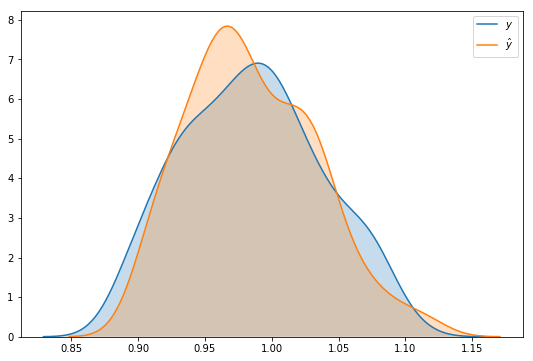

In [872]:
pred = ['IMD'] # try ['a_ln'], ['a_ln', 'F2266'], ['b_ln', 'F1816'], ['b_ln', 'ptrs'], ['age_med', 'b_ln']
out = 'food_total' # try 'total', 'food_total'

#compare distributions of predicted and actual values for both models 
f, ax = plt.subplots(1, figsize=(9, 6))

sns.kdeplot(data[out], shade=True, ax=ax, label='$y$')
sns.kdeplot(calculate_model(out, pred).fittedvalues, shade=True, ax=ax, label='$\hat{y}$')

plt.show()

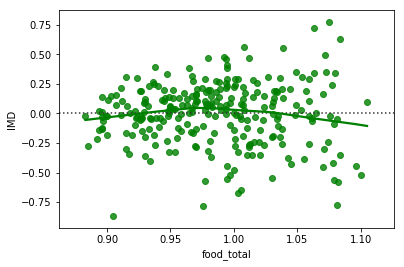

In [873]:
sns.residplot(data[out], data['IMD'], lowess=True, color="g")

Base model:  
                             OLS Regression Results                            
Dep. Variable:                  total   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     1338.
Date:                Wed, 15 May 2019   Prob (F-statistic):          9.92e-105
Time:                        11:56:43   Log-Likelihood:                 15.967
No. Observations:                 263   AIC:                            -27.93
Df Residuals:                     261   BIC:                            -20.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.4440      0.063    1

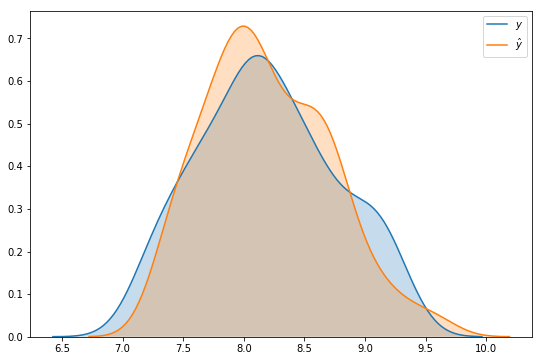

In [874]:
pred = ['IMD'] # try ['a_ln'], ['a_ln', 'F2266'], ['b_ln', 'F1816'], ['b_ln', 'ptrs'], ['age_med', 'b_ln']
out = 'total' # try 'total', 'food_total'

#compare distributions of predicted and actual values for both models 
f, ax = plt.subplots(1, figsize=(9, 6))

sns.kdeplot(data[out], shade=True, ax=ax, label='$y$')
sns.kdeplot(calculate_model(out, pred).fittedvalues, shade=True, ax=ax, label='$\hat{y}$')

plt.show()

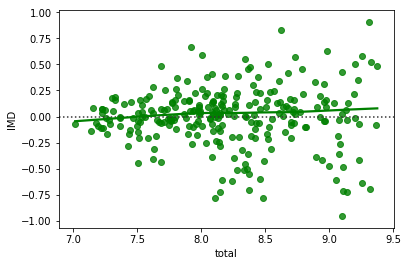

In [875]:
sns.residplot(data[out], data['IMD'], lowess=True, color="g")

# Spatial weights

In [876]:
spatial_data = data_lsoa.join(data, how='inner')

In [877]:
spatial_data.head()

FID_1     geo_label geo_labelw  Count_  \
E01014584     66  Bristol 045E       None       1   
E01014539    114  Bristol 025A       None       1   
E01014504    380  Bristol 041B       None       1   
E01014654    430  Bristol 056A       None       1   
E01014669    540  Bristol 020D       None       1   

                                                    geometry  total  \
E01014584  POLYGON ((358645.634 170187.736, 358640.859 17...  7.539   
E01014539  POLYGON ((358951 174048, 358959.518 174040.699...  8.664   
E01014504  POLYGON ((357372.001 171182.194, 357369.784 17...  8.538   
E01014654  POLYGON ((360104.977 174206.128, 360105.018 17...  7.521   
E01014669  POLYGON ((358550 175095, 358551 175095, 358551...  9.375   

           food_total  Restaurant_and_cafÃ©_meals     F2266    buk_ln  \
E01014584       0.937                       0.055  0.422828 -0.808689   
E01014539       1.017                       0.067  0.509815 -0.894848   
E01014504       1.018                       0.066  0.466311 -0.761473   
E01014654       0.927                       0.054  0.154111 -1.334700   
E01014669       1.080                       0.075  0.468439 -0.838807   

           age_med     F1816    emp_ft    unempl   act_lim    bdr_1p  \
E01014584     31.0  0.814727  0.154506  0.045064  0.105528  0.363248   
E01014539     27.0  0.456425  0.096234  0.016736  0.038713  0.201531   
E01014504     34.0  0.662544  0.089368  0.038521  0.064043  0.201220   
E01014654     28.0  0.584722  0.181607  0.088475  0.086096  0.394767   
E01014669     30.0  0.586466  0.090756  0.020168  0.033223  0.161031   

               ptrs  Income Deprivation       IMD  
E01014584  0.390244           -1.139403  3.938237  
E01014539  0.232348           -2.733214  2.643548  
E01014504  0.343505           -2.407835  2.918420  
E01014654  0.321494           -0.991526  3.999979  
E01014669  0.332271           -3.381101  2.209484

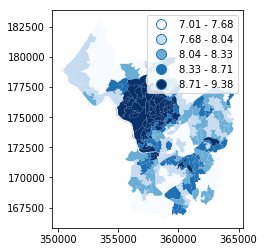

In [878]:
spatial_data.plot(column = 'total', scheme = 'quantiles', cmap ='Blues', legend = True)

In [879]:
spatial_data.reset_index().to_file('Data/Spatial/spatial_data.shp')

In [880]:
# two observations are neighbours if they share one point
w_queen = ps.weights.Queen.from_dataframe(spatial_data)

In [881]:
#sns.distplot(queen_card, bins=8)

In [882]:
print(w_queen.n, '\n', # Number of observations
      w_queen.mean_neighbors, '\n', # Average number of neighbors
      w_queen.min_neighbors, '\n', # Min number of neighbors
      w_queen.max_neighbors, '\n', # Max number of neighbors
      w_queen.islands, '\n', # Islands (observations disconnected)
     )

263 
 5.4600760456273765 
 2 
 10 
 [] 



# Spatial Lag

The spatial lag of a given variable is the product of a spatial weight matrix and the variable itself

In [883]:
# Row-standardize the queen matrix
'''
    O: original, returning the object to the initial state.
    B: binary, with every neighbor having assigned a weight of one.
    R: row, with all the neighbors of a given observation adding up to one.
    V: variance stabilizing, with the sum of all the weights being constrained to the number of observations.
'''
w_queen.transform = 'R'
# Compute spatial lag of `imd_score`
w_queen_score = ps.lag_spatial(w_queen, spatial_data['IMD'])
# Add as column
spatial_data['w_queen_imd'] = w_queen_score

# Moran's Plot

Text(0.5,1,"Moran's plot for total emissions")

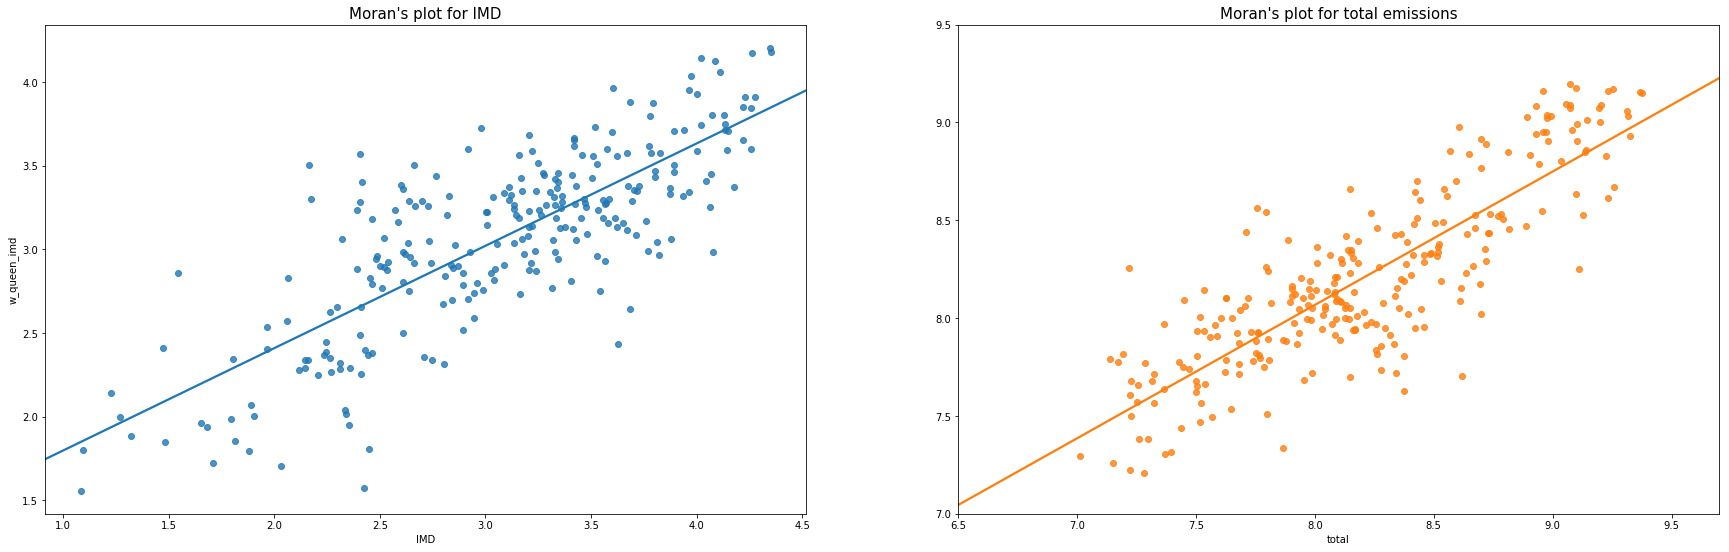

In [884]:
# Setup the figure and axis
f, (ax, ax1) = plt.subplots(nrows =1, ncols=2, figsize=(30, 9))

sns.regplot(ax=ax, x="IMD", y="w_queen_imd", data=spatial_data, ci=None)
ax.set_title("Moran's plot for IMD", size=15)

sns.regplot(ax=ax1, x=spatial_data["total"], y=ps.lag_spatial(w_queen, spatial_data['total']), ci=None)
ax1.set_ylim(7, 9.5)
ax1.set_xlim(6.5, 9.7)
ax1.set_title("Moran's plot for total emissions", size=15)

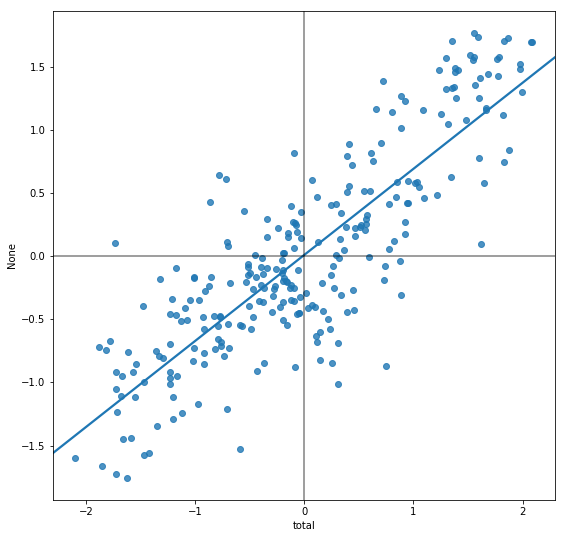

In [885]:
# Standardize total emissions to see quartiles (HH, HL, LH, LL)
std_co2 = (spatial_data['total'] - spatial_data['total'].mean()) / spatial_data['total'].std()
# Compute the spatial lag of the standardized version and save is as a 
# Series indexed as the original variable
std_w_co2 = pd.Series(ps.lag_spatial(w_queen, std_co2), index=std_co2.index)

# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot values
sns.regplot(x=std_co2, y=std_w_co2, ci=None)
# Add vertical and horizontal lines
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
# Display
plt.show()

# Spatial autocorrelation and Exploratory Spatial Data Analysis - Lab 06

In [886]:
np.random.seed(123)
w = ps.weights.Queen.from_dataframe(spatial_data)
w.transform = 'R'
spatial_data['w_total'] = ps.lag_spatial(w, spatial_data['total'])

# standardised total emissions
spatial_data['total_std'] = (spatial_data['total'] - spatial_data['total'].mean()) / spatial_data['total'].std()
spatial_data['w_total_std'] = ps.lag_spatial(w, spatial_data['total_std'])

## Global Spatial autocorrelation

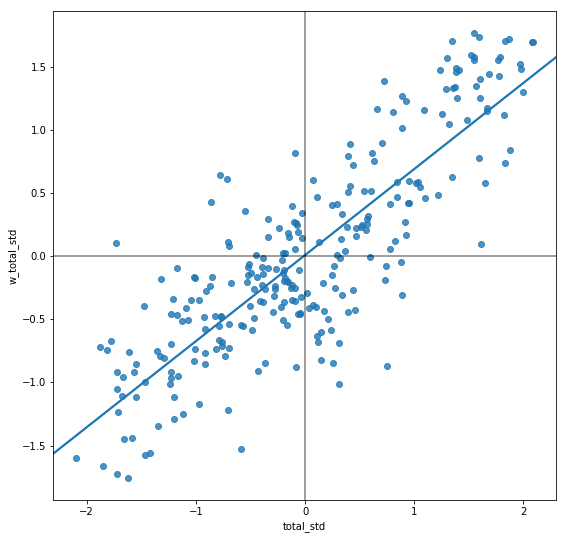

'\nThe plot displays a positive relationship between both variables. \nThis is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. \nThis means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values.\n'

In [887]:
# Moran plot

f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='total_std', y='w_total_std', data=spatial_data, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()
'''
The plot displays a positive relationship between both variables. 
This is associated with the presence of positive spatial autocorrelation: similar values tend to be located close to each other. 
This means that the overall trend is for high values to be close to other high values, and for low values to be surrounded by other low values.
'''

In [888]:
# Moran's I
mi = ps.Moran(spatial_data['total'], w) # Note how we do not need to use the standardized version in this context as we will not represent it visually.
print("Moran's I: " + str(mi.I), '\n', "p-value: " + str(mi.p_sim))

'''
Moran's I is good tool to summarize a dataset into a single value that informs about its degree of clustering. 
However, it is not an appropriate measure to identify areas within the map where specific values are located.
'''

Moran's I: 0.6815938922451394 
 p-value: 0.001


"\nMoran's I is good tool to summarize a dataset into a single value that informs about its degree of clustering. \nHowever, it is not an appropriate measure to identify areas within the map where specific values are located.\n"

## Local Spatial autocorrelation

Can help identify *where* clusters are

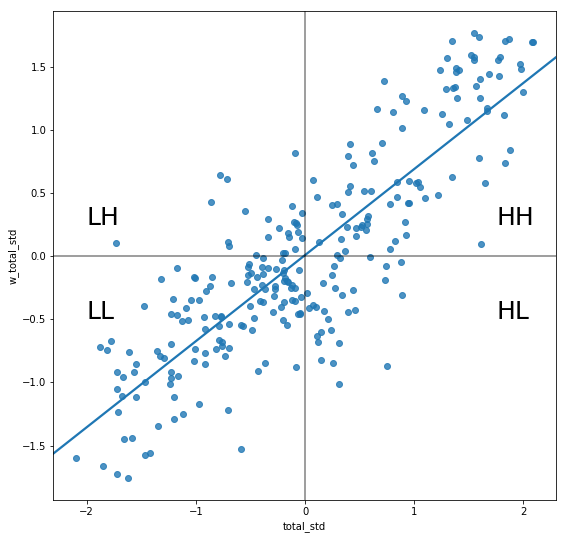

In [889]:
f, ax = plt.subplots(1, figsize=(9, 9))
sns.regplot(x='total_std', y='w_total_std', data=spatial_data, ci=None)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.text(1.75, 0.25, "HH", fontsize=25)
plt.text(1.75, -0.5, "HL", fontsize=25)
plt.text(-2, 0.25, "LH", fontsize=25)
plt.text(-2, -0.5, "LL", fontsize=25)
plt.show()

In [890]:
'''
Now we need to see how each of these compares to what we would expect by random chance. 
This is exactly what LISAs are designed to do. As before, a more detailed description of their statistical underpinnings is beyond the scope in this context, but we will try to shed some light into the 
intuition of how they go about it. The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) 
or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation, resulting then in as
many statistics as original observations.
'''

lisa = ps.Moran_Local(spatial_data['total'], w)

# Store p-values
spatial_data['pvalue'] = lisa.p_sim
# Break observations into significant or not
spatial_data['significant'] = lisa.p_sim < 0.05
# Store the quadrant they belong to
spatial_data['quadrant'] = lisa.q

In [891]:
quadrant_code = {1: 'HH', 2: 'LH', 3: 'LL', 4: 'HL'}
quad_def=[quadrant_code[i] for i in spatial_data['quadrant']]

spatial_data['quadrant_def'] = quad_def

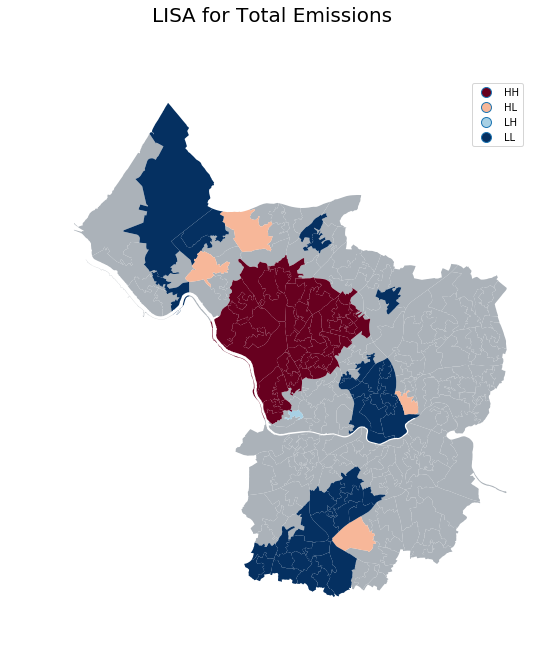

In [892]:
f, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
f.suptitle('LISA for Total Emissions', size=20)

# short way
# Plot insignificant clusters
ns = spatial_data.loc[spatial_data['significant']==False, 'geometry']
ns.plot(ax=ax1, color='#abb2b9')

# Plot HH clusters
sig = spatial_data.loc[spatial_data['significant']==True]
sig.plot(ax=ax1, column = 'quadrant_def', cmap='RdBu', legend= True)
ax1.set_axis_off()

plt.savefig('Outputs/autocorr_map.png')

# Clustering, spatial clustering, and geodemographics - Lab 08

__Food Clusters__

In [966]:
col_FoodDrink = col_FoodDrink[:39] + ['Restaurant_and_cafÃ©_meals']

In [968]:
min_max_scaler = preprocessing.MinMaxScaler()
data_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[col_FoodDrink[:40]].astype(float)))
data_mm.index = data_co2[col_FoodDrink[:40]].index

to_keep = data_co2[col_FoodDrink[:40]].columns.to_list()
to_keep_mm = []
for var in to_keep:
    to_keep_mm.append(var + '_mm')
data_mm.columns = to_keep_mm

data_8 = spatial_data.join(data_mm[to_keep_mm])

In [969]:
w = ps.weights.Queen.from_dataframe(data_8)

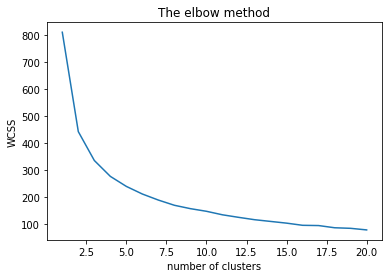

In [970]:
# Perform PCA
pca=PCA(n_components=None) # Create an instance of the PCA class

# Fit the data to the model
pcaResults=pca.fit_transform(data_8[to_keep_mm])
explained_variance=pca.explained_variance_ratio_ # Extract the varience

# use the elbow method
wcss=[]

for i in range(1,21):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(pcaResults)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS results
plt.plot(range(1,21), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

In [971]:
# add spatial contraint
sagg13 = cluster.AgglomerativeClustering(n_clusters=5, connectivity=w.sparse)

# This line is required to obtain the same results always
np.random.seed(1234)
# Run the clustering algorithm
sagg13cls = sagg13.fit(data_8[to_keep_mm])

# add labels as column
data_8['sagg13cls'] = sagg13cls.labels_

In [972]:
import random

mycmap_list = ['#f1c40f', '#619864', '#2a80b9', '#c1392b', '#bec3c7']
random.shuffle(mycmap_list)
mycmap = matplotlib.colors.ListedColormap(mycmap_list, N=None)

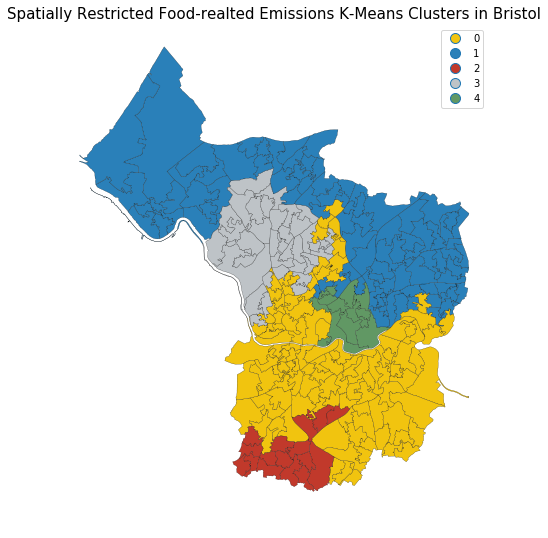

In [973]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
data_8.plot(column='sagg13cls', cmap=mycmap, categorical=True, legend=True, linewidth=0.2, facecolor='white', edgecolor='k', ax=ax)
# Add title
plt.title('Spatially Restricted Food-realted Emissions K-Means Clusters in Bristol', size=15)
ax.set_axis_off()
# Display the map
plt.savefig('Outputs/food_clusters.png')
plt.show()

In [974]:
def dissolve(gs):
    '''
    Take a series of polygons and dissolve them into a single one
    
    Arguments
    ---------
    gs        : GeoSeries
                Sequence of polygons to be dissolved
    Returns
    -------
    dissolved : Polygon
                Single polygon containing all the polygons in `gs`
    '''
    return gs.unary_union

In [975]:
# Dissolve the polygons based on `sagg13cls`
food_clusters = gpd.GeoSeries(data_8.groupby(data_8['sagg13cls'])\
                                    .apply(dissolve),
                              crs=data_8.crs)

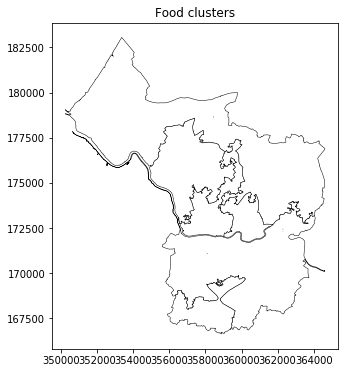

In [976]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot boundary lines
food_clusters.plot(ax=ax, linewidth=0.5, facecolor='white', edgecolor='k')

# Add title
plt.title('Food clusters')
# Display the map
plt.show()

In [977]:
food_2 = gpd.GeoDataFrame(food_clusters, crs=data_8.crs).rename(columns={0:'geometry'})

In [978]:
food_2.head()

geometry
sagg13cls                                                   
0          (POLYGON ((358002.5 172148.526, 357886.7 17215...
1          (POLYGON ((353219.815 175865.997, 353221.099 1...
2          POLYGON ((358814.19 168516.497, 358814.405 168...
3          (POLYGON ((358100.943 174112.588, 358082.727 1...
4          POLYGON ((359304 172263, 359311.389 172269.085...

In [979]:
all_spatial = gpd.sjoin(data_8, food_2).drop('index_right', axis=1)

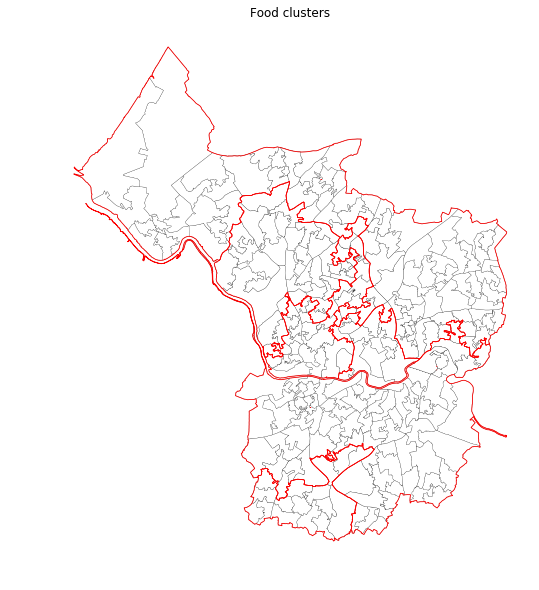

In [980]:
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(10, 10))
# Plot boundary lines
all_spatial.plot(ax=ax, linewidth=0.2, facecolor='white', edgecolor='k')
#food_clusters.plot(ax=ax, linewidth=0.5, facecolor='white', edgecolor='k')
food_2.boundary.plot(ax=ax, linewidth=0.8, edgecolor='red')
ax.set_axis_off()
# Add title
plt.title('Food clusters')
# Display the map
plt.show()

In [981]:
new_cols = []
for item in col_FoodDrink:
    new_cols.append(item + '_mm')
new_cols.append('food_total')
new_cols.append('total')
new_cols.append('sagg13cls')
#new_cols.remove('Pastry_mm')

In [1052]:
mm_dat = all_spatial[new_cols]
mm_dat.columns = mm_dat.columns.str.replace('_mm', '')

temp2 = mm_dat.groupby('sagg13cls').describe().T.join(all_spatial[['sagg13cls']].join(data_co2[col_FoodDrink]).groupby('sagg13cls').describe().T, lsuffix = '_mm')

temp2.to_csv('Outputs/summary_by_cluster_spares.csv')

mm_dat.groupby('sagg13cls').mean().T.join(all_spatial[['sagg13cls']].join(data_co2[col_FoodDrink]).groupby('sagg13cls').mean().T, lsuffix = '_mm').drop(['total', 'food_total']).sum()

sagg13cls
0_mm    18.011092
1_mm    13.022459
2_mm     5.006946
3_mm    28.435718
4_mm     4.521563
0        0.997681
1        0.963274
2        0.913040
3        1.067919
4        0.907960
dtype: float64

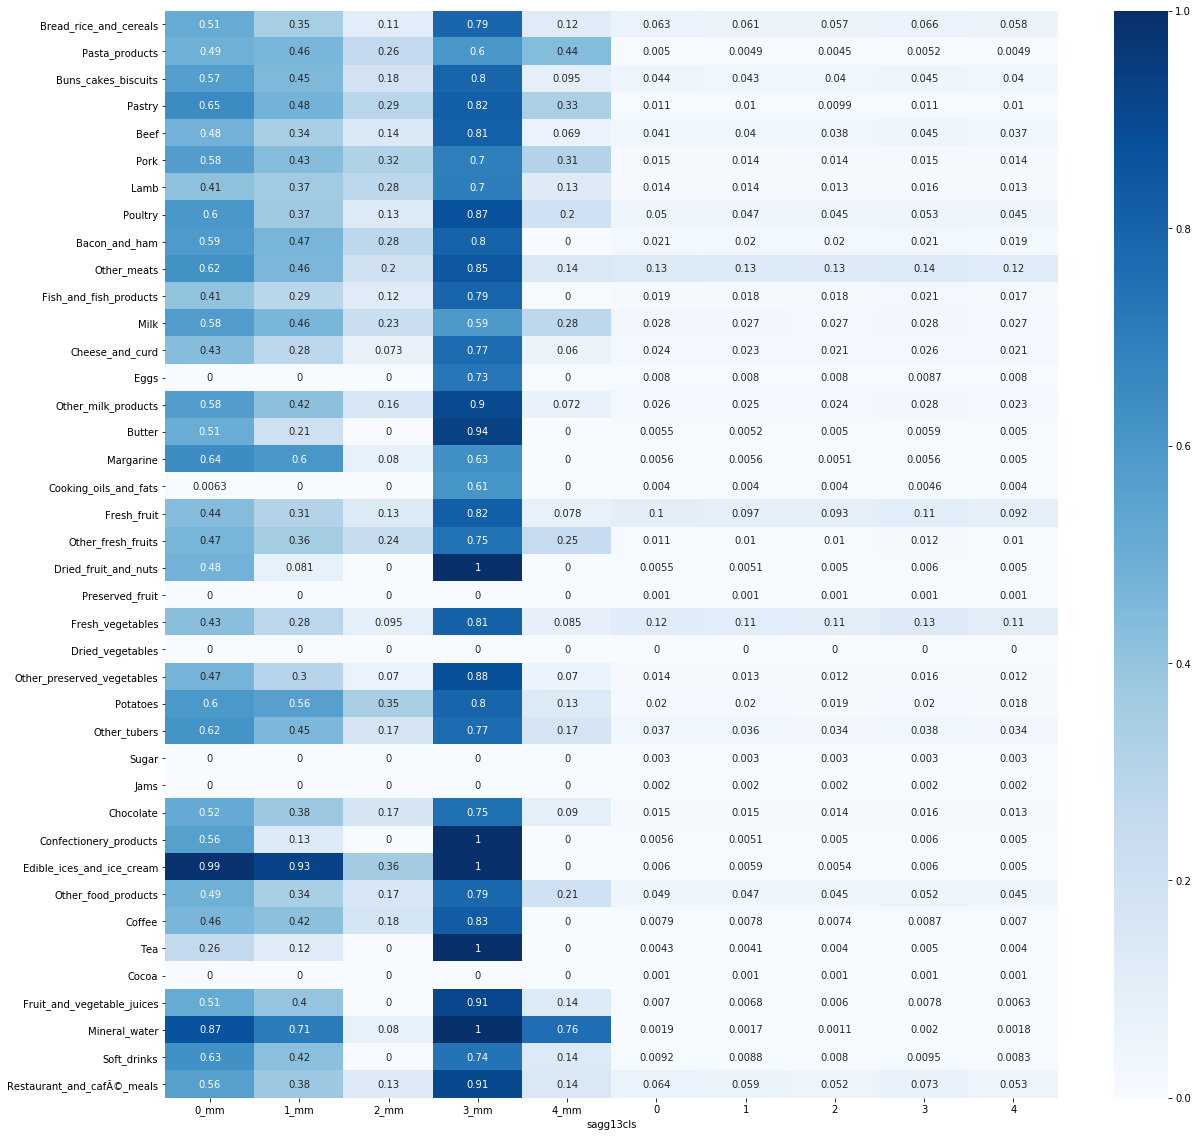

In [1053]:
plt.subplots(figsize=(20,20))
sns.heatmap(mm_dat.groupby('sagg13cls').mean().T.join(all_spatial[['sagg13cls']].join(data_co2[col_FoodDrink]).groupby('sagg13cls').mean().T, lsuffix = '_mm').drop(['total', 'food_total']),
            annot=True,
            cmap='Blues')

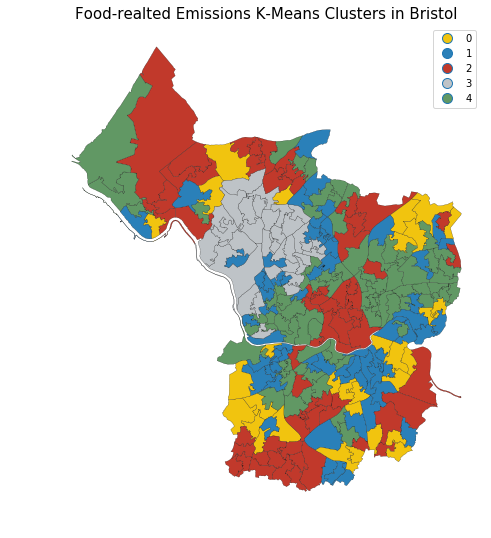

In [983]:
# Not resticted

km2=cluster.KMeans(n_clusters=5)

np.random.seed(0) #seed to ensure that analysis can be replicated
k2cls=km2.fit(data_8[to_keep_mm])

# add labels as column
data_8['sagg13cls'] = k2cls.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
data_8.plot(column='sagg13cls', cmap=mycmap, categorical=True, legend=True, linewidth=0.2, facecolor='white', edgecolor='k', ax=ax)
# Add title
plt.title('Food-realted Emissions K-Means Clusters in Bristol', size=15)
ax.set_axis_off()
# Display the map
plt.savefig('Outputs/food_clusters_nores.png')
plt.show()

In [1037]:
mydat = data_8[to_keep_mm + ['sagg13cls']]
mydat.columns = mydat.columns.str.replace('_mm', '')

temp = mydat.groupby('sagg13cls').describe().T.join(data_8[['sagg13cls']].join(data_co2[col_FoodDrink]).groupby('sagg13cls').describe().T, lsuffix = '_mm')

temp.to_csv('Outputs/summary_by_cluster_nores.csv')

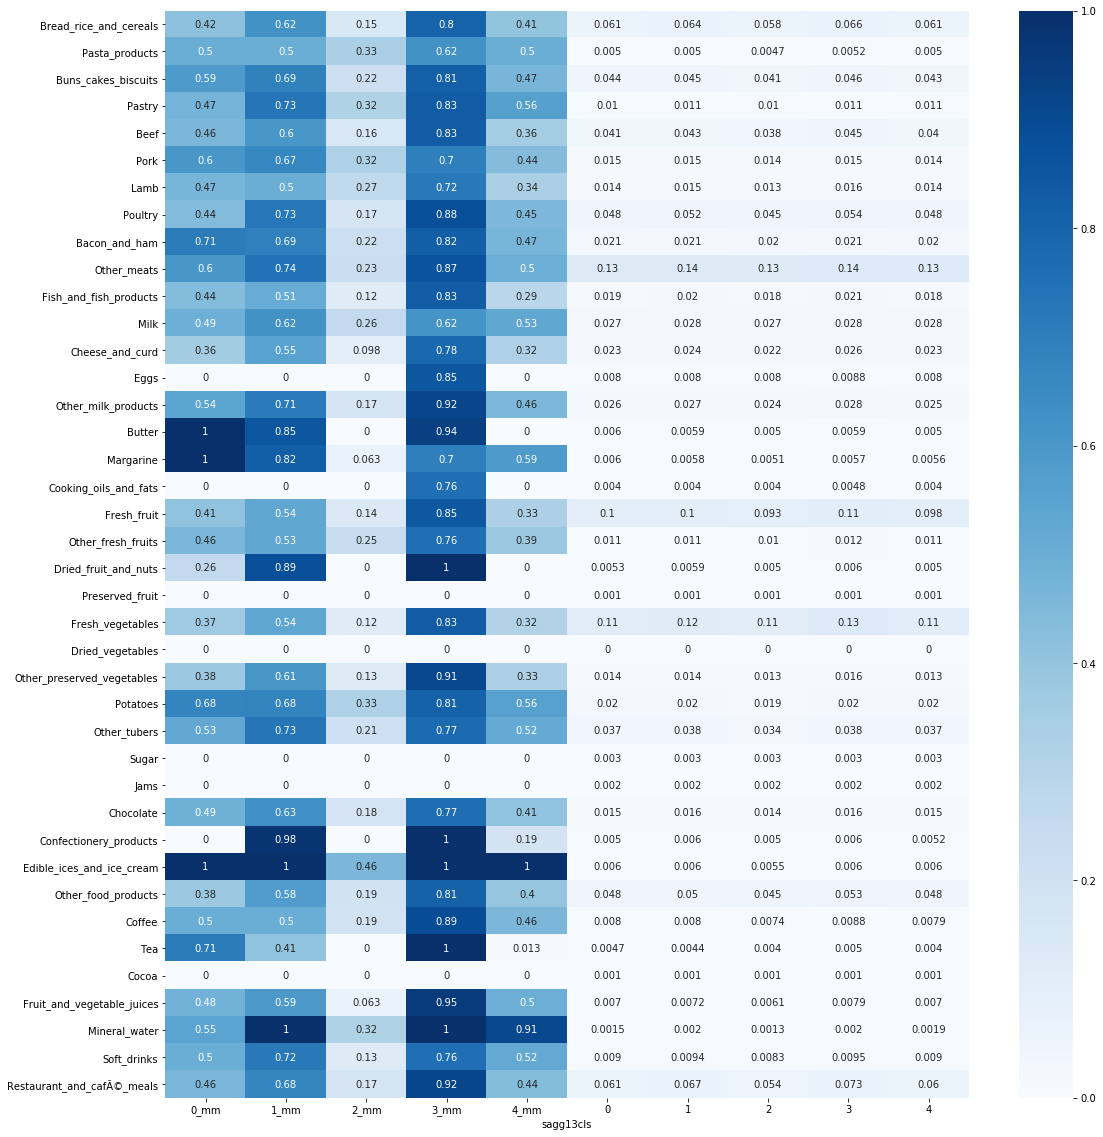

In [1046]:
temp = mydat.groupby('sagg13cls').mean().T.join(data_8[['sagg13cls']].join(data_co2[col_FoodDrink]).groupby('sagg13cls').mean().T, lsuffix = '_mm')


plt.subplots(figsize=(18,20))
sns.heatmap(temp,
            annot=True,
            cmap='Blues')

In [1039]:
temp.sum()

sagg13cls
0_mm    17.270429
1_mm    22.156146
2_mm     5.978196
3_mm    29.294207
4_mm    13.943514
0        0.986419
1        1.023066
2        0.918984
3        1.072515
4        0.971840
dtype: float64

In [ ]:
dat_norm = data_co2[tot_list].join(data_8[['sagg13cls']])

plt.subplots(figsize=(20,50))
sns.heatmap(data_mm.join(data_8[['sagg13cls']]).groupby('sagg13cls').mean().T.join(dat_norm.groupby('sagg13cls').mean().T, lsuffix='_mm', rsuffix=''),
            annot=True,
            cmap='Blues')
plt.savefig('Outputs/tl_clust_nores.png')

dat_mm = data_8.drop('geometry', axis=1).groupby('sagg13cls').describe().T.drop_duplicates()
dat_norm = data_co2[tot_list].join(data_8[['sagg13cls']]).groupby('sagg13cls').describe().T.drop_duplicates()

nores = dat_mm.join(dat_norm,lsuffix='_mm', rsuffix='').to_csv('Outputs/tl_clust_nores.csv')

__Total Clusters__

In [910]:
tot_list = []
cat_list_mm = []

for i in range(len(cat_list)):
    c = []
    for j in range(len(cat_list[i])):
        a = cat_list[i][j]
        c.append(a)
    cat_list_mm.append(c)
    for j in range(len(cat_list[i])):
        a = cat_list[i][j]
        b = a + '_mm'
        cat_list_mm[i][j] = b
        if a not in tot_list:
            tot_list.append(a)
        else:
            pass

In [911]:
data_mm = pd.DataFrame(min_max_scaler.fit_transform(data_co2[tot_list].astype(float)))
data_mm.index = data_co2[tot_list].index
data_mm.columns = data_co2[tot_list].columns

data_8 = spatial_data[['geometry']].join(data_mm)

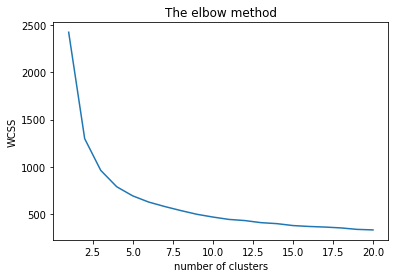

In [912]:
# Perform PCA
pca=PCA(n_components=None) # Create an instance of the PCA class

# Fit the data to the model
pcaResults=pca.fit_transform(data_mm)
explained_variance=pca.explained_variance_ratio_ # Extract the varience

# use the elbow method
wcss=[]

for i in range(1,21):
    kmeans=KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=20, random_state=0)
    kmeans.fit(pcaResults)
    wcss.append(kmeans.inertia_)
    
# Plot the WCSS results
plt.plot(range(1,21), wcss)
plt.title('The elbow method')
plt.xlabel('number of clusters')
plt.ylabel('WCSS')
plt.show()

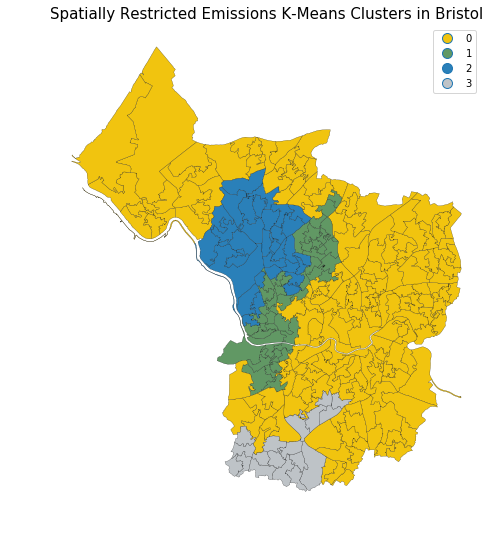

In [913]:
# Spatially resticted

w = ps.weights.Queen.from_dataframe(data_8)

# add spatial contraint
sagg13 = cluster.AgglomerativeClustering(n_clusters=4, connectivity=w.sparse)

# This line is required to obtain the same results always
np.random.seed(1234)
# Run the clustering algorithm
sagg13cls = sagg13.fit(data_8.drop('geometry', axis=1))

# add labels as column
data_8['sagg13cls'] = sagg13cls.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
data_8.plot(column='sagg13cls', cmap=mycmap, categorical=True, legend=True, linewidth=0.2, facecolor='white', edgecolor='k', ax=ax)
# Add title
plt.title('Spatially Restricted Emissions K-Means Clusters in Bristol', size=15)
ax.set_axis_off()
# Display the map
plt.savefig('Outputs/tot_clusters_spares.png')
plt.show()

In [914]:
'''

#plot variables by k-means clusters
for i in range(len(cat_list_mm)):
    tidy = data_8[cat_list_mm[i]].stack()\
                                 .reset_index()\
                                 .rename(columns={0:'value','level_1':'var', 'level_0':'GEO_CODE'})\
                                 .set_index('GEO_CODE')\
                                 .join(data_8[['sagg13cls']])
    g=sns.FacetGrid(col='var', hue='sagg13cls', data=tidy,
                  sharey=False, sharex=False, aspect=0.85)
    g.map(sns.kdeplot, 'value', shade=True).add_legend();
    name = 'cluster_spares_' + str(i)
    g.savefig('Outputs/'+name+'.png')
    
    '''

"\n\n#plot variables by k-means clusters\nfor i in range(len(cat_list_mm)):\n    tidy = data_8[cat_list_mm[i]].stack()                                 .reset_index()                                 .rename(columns={0:'value','level_1':'var', 'level_0':'GEO_CODE'})                                 .set_index('GEO_CODE')                                 .join(data_8[['sagg13cls']])\n    g=sns.FacetGrid(col='var', hue='sagg13cls', data=tidy,\n                  sharey=False, sharex=False, aspect=0.85)\n    g.map(sns.kdeplot, 'value', shade=True).add_legend();\n    name = 'cluster_spares_' + str(i)\n    g.savefig('Outputs/'+name+'.png')\n    \n    "

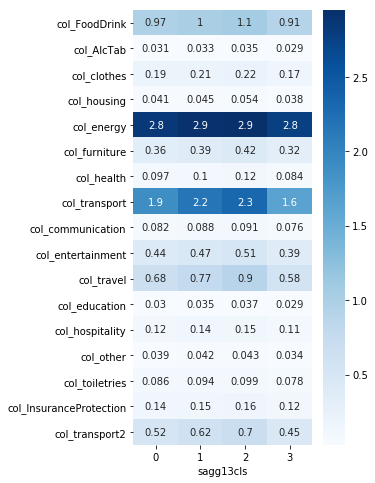

In [915]:
tot_list = data_mm.columns.tolist()

data_temp = data_co2[['TOTAL']].join(data_co2[cat_str]).join(data_8[['sagg13cls']])
data_temp.groupby('sagg13cls').describe().T.to_csv('Outputs/all_clust_spares.csv')

plt.subplots(figsize=(4,8))
sns.heatmap(data_temp.drop('TOTAL', axis=1).groupby('sagg13cls').mean().T,
            annot=True,
            cmap='Blues')
plt.savefig('Outputs/all_clust_spares.png')

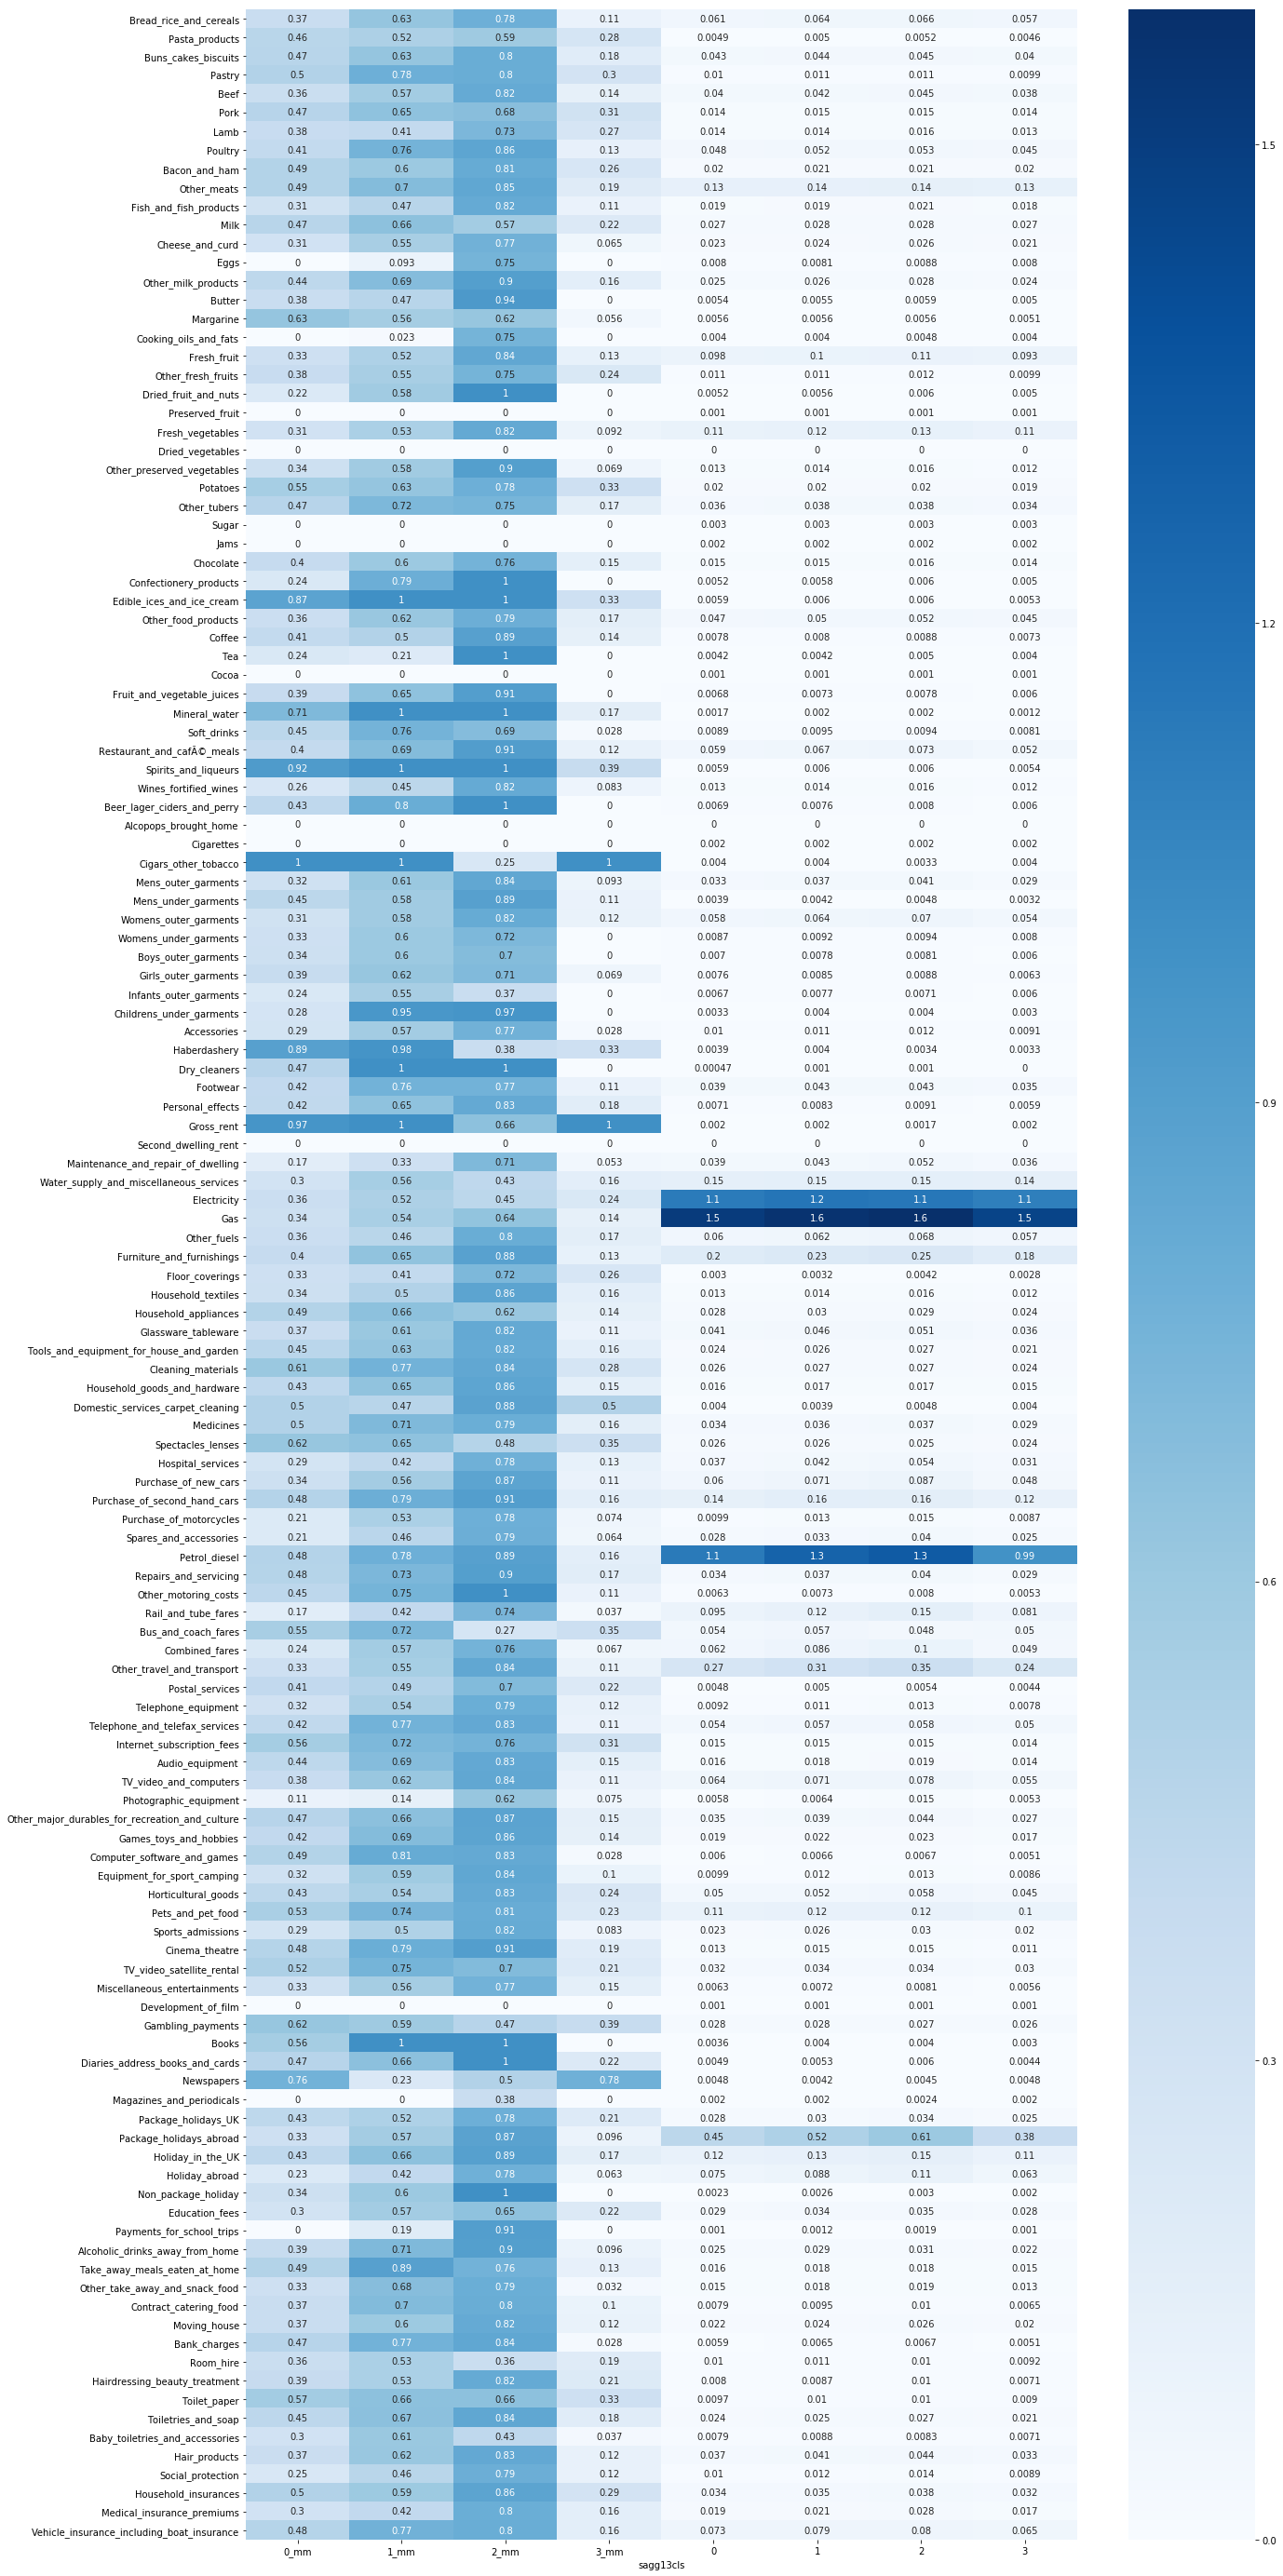

In [916]:
dat_norm = data_co2[tot_list].join(data_8[['sagg13cls']])

plt.subplots(figsize=(20,50))
sns.heatmap(data_mm.join(data_8[['sagg13cls']]).groupby('sagg13cls').mean().T.join(dat_norm.groupby('sagg13cls').mean().T, lsuffix='_mm', rsuffix=''),
            annot=True,
            cmap='Blues')
plt.savefig('Outputs/tl_clust_spares.png')

dat_mm = data_8.drop('geometry', axis=1).groupby('sagg13cls').describe().T.drop_duplicates()
dat_norm = data_co2[tot_list].join(data_8[['sagg13cls']]).groupby('sagg13cls').describe().T.drop_duplicates()

spares = dat_mm.join(dat_norm,lsuffix='_mm', rsuffix='').to_csv('Outputs/tl_clust_spares.csv')

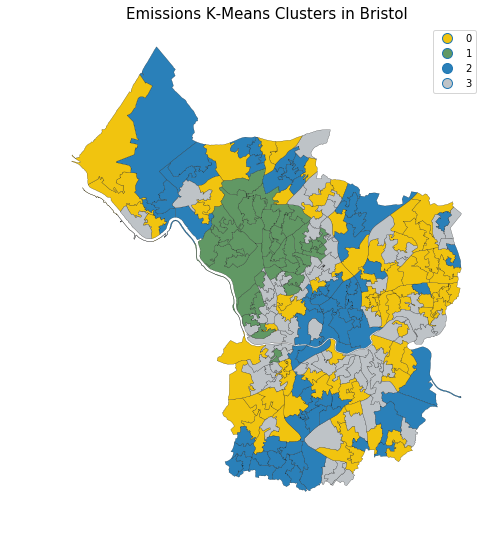

In [917]:
# Not resticted

km2=cluster.KMeans(n_clusters=4)

np.random.seed(0) #seed to ensure that analysis can be replicated
k2cls=km2.fit(data_8[tot_list])

# add labels as column
data_8['sagg13cls'] = k2cls.labels_

# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
data_8.plot(column='sagg13cls', cmap=mycmap, categorical=True, legend=True, linewidth=0.2, facecolor='white', edgecolor='k', ax=ax)
# Add title
plt.title('Emissions K-Means Clusters in Bristol', size=15)
ax.set_axis_off()
# Display the map
plt.savefig('Outputs/tot_clusters_nores.png')
plt.show()

In [918]:
'''
#plot variables by k-means clusters
for i in range(len(cat_list_mm)):
    tidy = data_8[cat_list_mm[i]].stack()\
                                 .reset_index()\
                                 .rename(columns={0:'value','level_1':'var', 'level_0':'GEO_CODE'})\
                                 .set_index('GEO_CODE')\
                                 .join(data_8[['sagg13cls']])
    g=sns.FacetGrid(col='var', hue='sagg13cls', data=tidy,
                  sharey=False, sharex=False, aspect=0.85)
    g.map(sns.kdeplot, 'value', shade=True).add_legend();
    name = 'cluster_nores_' + str(i)
    g.savefig('Outputs/'+name+'.png')
'''

"\n#plot variables by k-means clusters\nfor i in range(len(cat_list_mm)):\n    tidy = data_8[cat_list_mm[i]].stack()                                 .reset_index()                                 .rename(columns={0:'value','level_1':'var', 'level_0':'GEO_CODE'})                                 .set_index('GEO_CODE')                                 .join(data_8[['sagg13cls']])\n    g=sns.FacetGrid(col='var', hue='sagg13cls', data=tidy,\n                  sharey=False, sharex=False, aspect=0.85)\n    g.map(sns.kdeplot, 'value', shade=True).add_legend();\n    name = 'cluster_nores_' + str(i)\n    g.savefig('Outputs/'+name+'.png')\n"

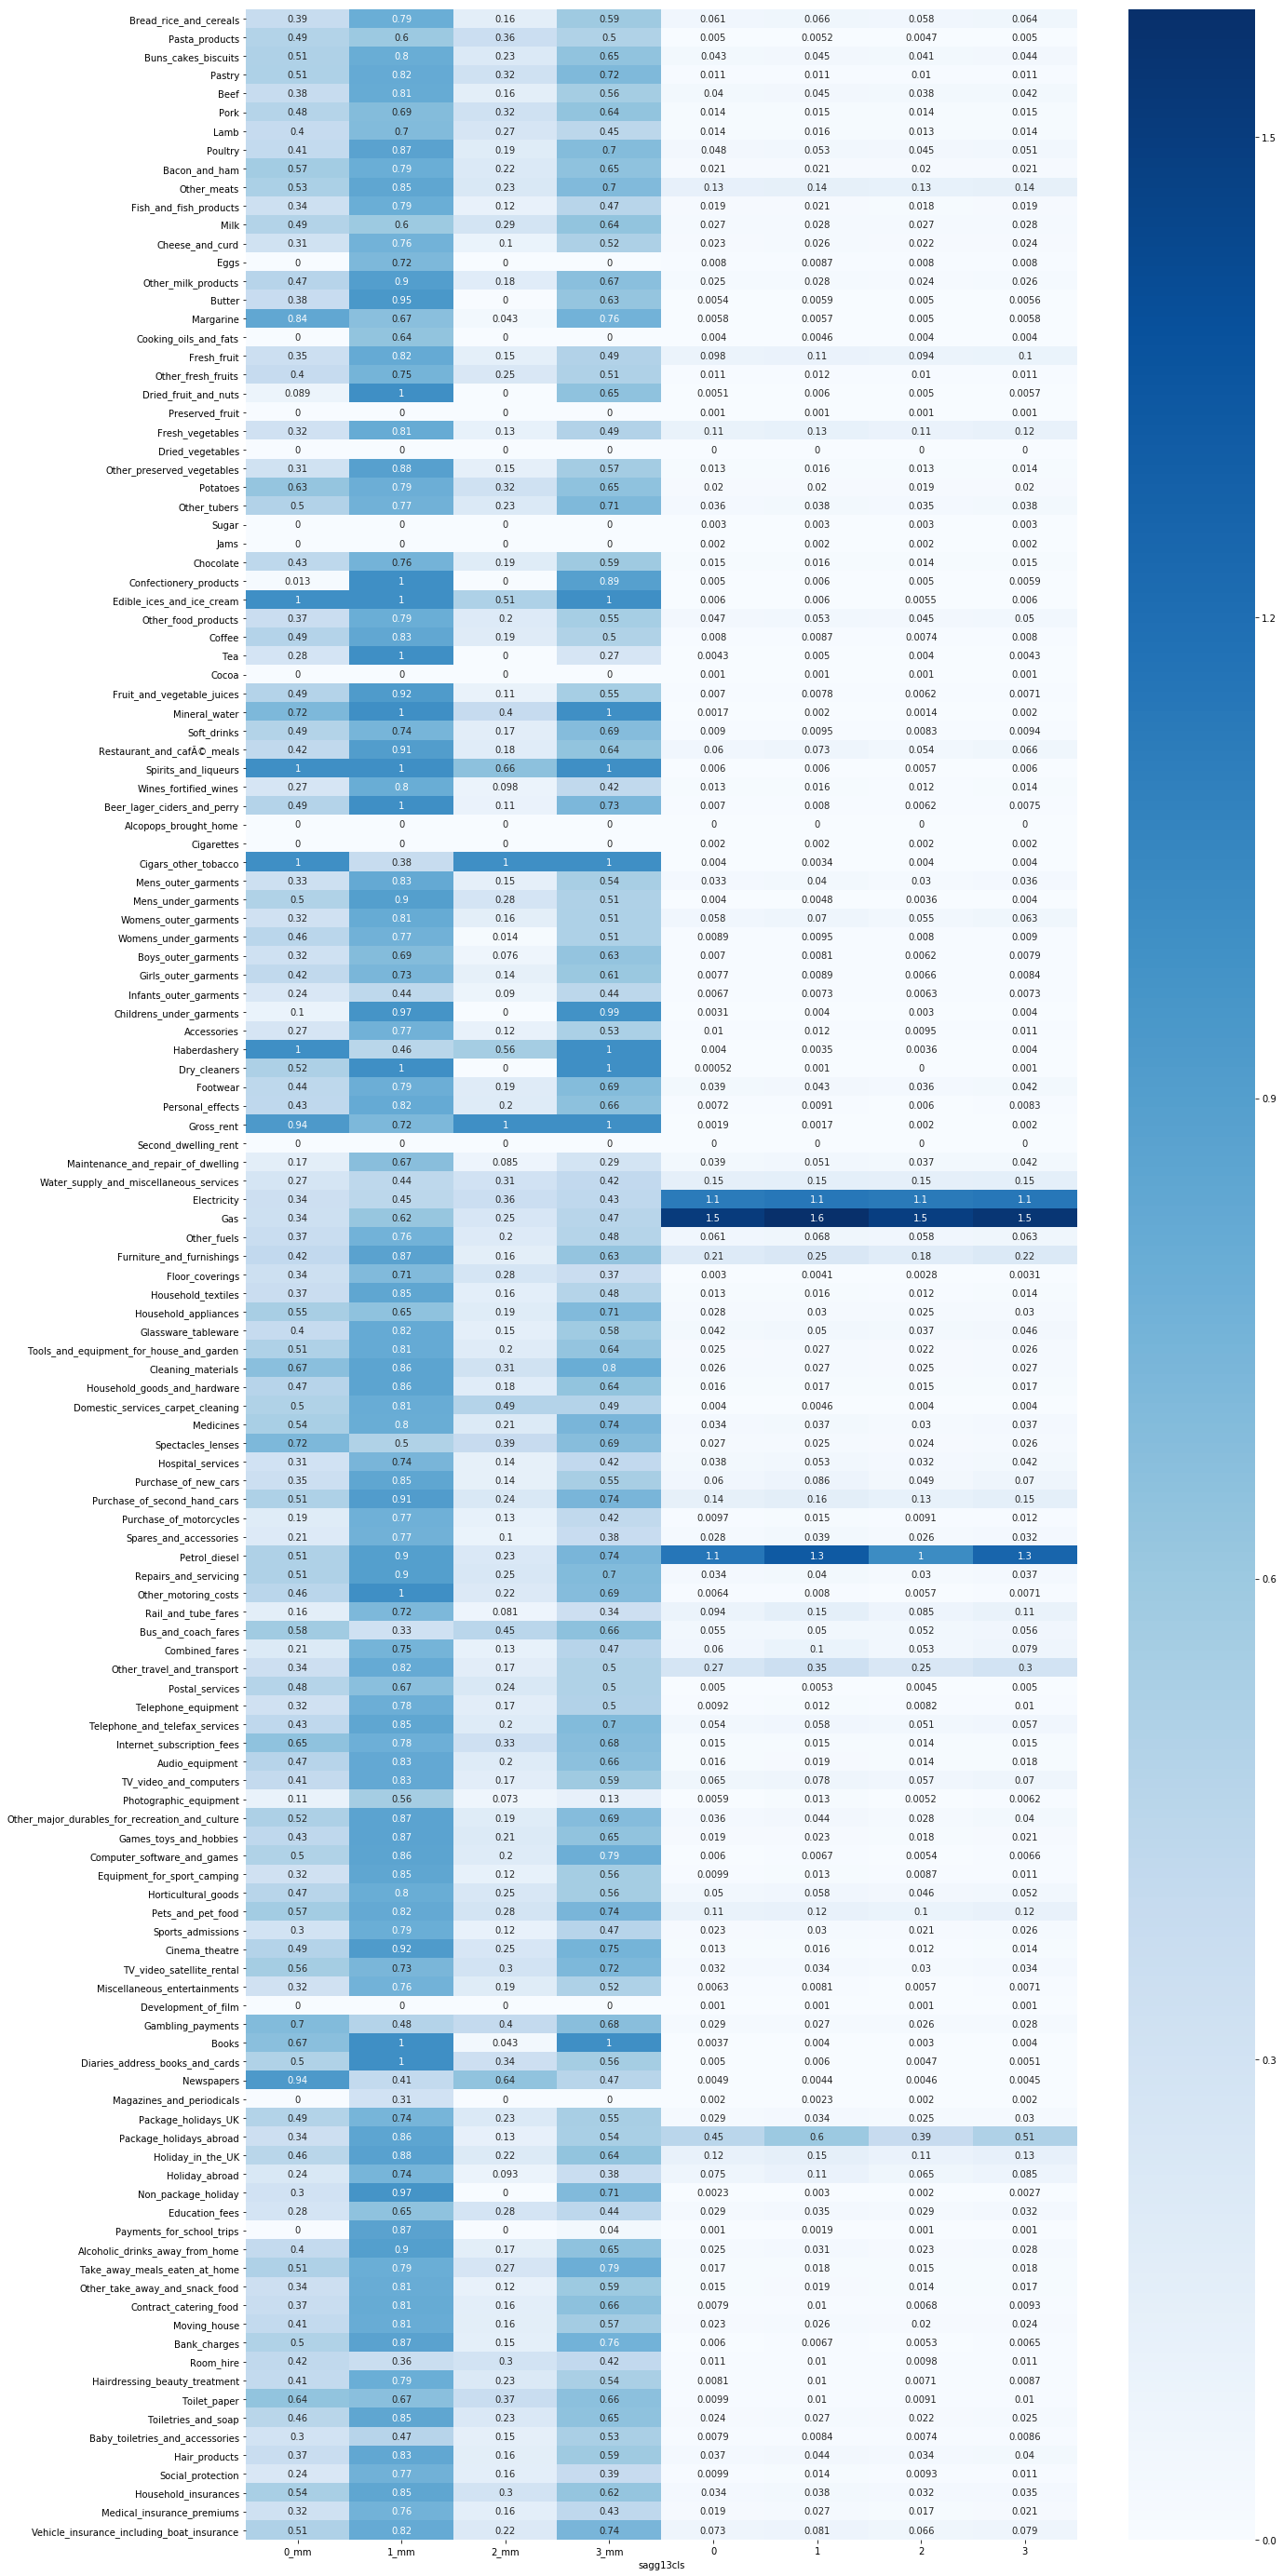

In [919]:
dat_norm = data_co2[tot_list].join(data_8[['sagg13cls']])

plt.subplots(figsize=(20,50))
sns.heatmap(data_mm.join(data_8[['sagg13cls']]).groupby('sagg13cls').mean().T.join(dat_norm.groupby('sagg13cls').mean().T, lsuffix='_mm', rsuffix=''),
            annot=True,
            cmap='Blues')
plt.savefig('Outputs/tl_clust_nores.png')

dat_mm = data_8.drop('geometry', axis=1).groupby('sagg13cls').describe().T.drop_duplicates()
dat_norm = data_co2[tot_list].join(data_8[['sagg13cls']]).groupby('sagg13cls').describe().T.drop_duplicates()

nores = dat_mm.join(dat_norm,lsuffix='_mm', rsuffix='').to_csv('Outputs/tl_clust_nores.csv')

In [920]:
tidy = data_co2[tot_list].stack()\
             .reset_index()\
             .rename(columns={0:'value','level_1':'var'})\
             .set_index('LSOA')\
             .join(data_8[['sagg13cls']])

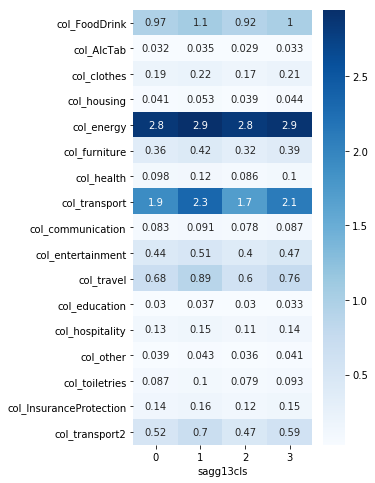

In [921]:
data_temp = data_co2[['TOTAL']].join(data_co2[cat_str]).join(data_8[['sagg13cls']])
data_temp.groupby('sagg13cls').describe().T.to_csv('Outputs/all_clust_nores.csv')

plt.subplots(figsize=(4,8))
sns.heatmap(data_temp.drop('TOTAL', axis=1).groupby('sagg13cls').mean().T,
            annot=True,
            cmap='Blues')
plt.savefig('Outputs/all_clust_nores.png')

In [922]:
all_tot_clus = nores.join(spares, lsuffix='_nr', rsuffix='_sr')
all_tot_clus.to_csv('Outputs/all_clusters_tot.csv')

AttributeError: 'NoneType' object has no attribute 'join'